In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})


In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia']
N_STATES_RANGE = range(2, 21)  # 1 to 19 states

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#377eb8',    # Blue
    'paranoia_light': '#6699ff' # Light blue
}


## Figure 2

In [17]:
SAVE_DIR_FIG2 = Path(SAVE_DIR) / "figure2"
SAVE_DIR_FIG2.mkdir(parents=True, exist_ok=True)

In [5]:
def load_data(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics"
    
    # Load metrics
    metrics_path = base_path / f"{group}_metrics.pkl"
    try:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
    except Exception as e:
        print(f"Error loading metrics for {group}, n_state={n_state}: {e}")
        metrics = None
    
    # Load summary
    summary_path = base_path / f"{group}_summary.json"
    try:
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    except Exception as e:
        print(f"Error loading summary for {group}, n_state={n_state}: {e}")
        summary = None
    
    return {'metrics': metrics, 'summary': summary}

def extract_model_metrics(data: Dict) -> Dict:
    """Extract relevant metrics from both metrics and summary files."""
    metrics = {}
    
    try:
        metrics_data = data['metrics']
        summary_data = data['summary']
        
        if metrics_data:
            # Get state frequencies and calculate percentage below threshold
            state_freq_mean = metrics_data['subject_consistency']['summary']['state_frequency']['mean']
            metrics['pct_low_freq'] = np.mean(state_freq_mean < 0.1) * 100
            
            # Get pattern correlations variance
            pattern_corr = metrics_data['subject_consistency']['pattern_correlation']
            state_variances = np.var(pattern_corr, axis=0)
            metrics['max_pattern_var'] = np.max(state_variances)
            
            # Get mean pattern stability
            state_props = metrics_data['state_properties']
            pattern_stabilities = []
            for key in state_props.keys():
                if isinstance(key, (int, str)) and key != 'separability':
                    if isinstance(key, str) and key.isdigit():
                        key = int(key)
                    pattern_stabilities.append(state_props[key]['pattern_stability'])
            metrics['mean_pattern_stability'] = np.mean(pattern_stabilities)
        
        if summary_data:
            # Extract BIC and log-likelihood
            metrics['bic'] = summary_data['model_performance']['bic']
            metrics['log_likelihood'] = summary_data['model_performance']['log_likelihood']
        
    except Exception as e:
        print(f"Error extracting metrics: {e}")
        return None
        
    return metrics

In [24]:
def explore_dict_structure(d, prefix=''):
    """
    Recursively explore and print the structure of nested dictionaries.
    
    Args:
        d: Dictionary or other object to explore
        prefix: String prefix for indentation and nesting
    """
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, (dict, list, np.ndarray)):
                print(f"{prefix}{key}: {type(value)}")
                if isinstance(value, dict):
                    explore_dict_structure(value, prefix + '  ')
                elif isinstance(value, list):
                    print(f"{prefix}  Length: {len(value)}")
                elif isinstance(value, np.ndarray):
                    print(f"{prefix}  Shape: {value.shape}")
            else:
                print(f"{prefix}{key}: {type(value)} = {value}")

# Load and explore one metrics file
group = 'affair'
n_state = 3  # Let's look at the 3-state model
filepath = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics" / f"{group}_metrics.pkl"

print(f"\nExploring structure of metrics file for {group}, n_states={n_state}:")
print(f"File path: {filepath}\n")

with open(filepath, 'rb') as f:
    data = pickle.load(f)
    explore_dict_structure(data)


Exploring structure of metrics file for affair, n_states=3:
File path: /orcd/scratch/bcs/001/yibei/prettymouth/output/affair_hmm_3states_ntw_native_trimmed/statistics/affair_metrics.pkl

state_metrics: <class 'dict'>
  subject_level: <class 'dict'>
    0: <class 'dict'>
      durations: <class 'dict'>
        0: <class 'list'>
          Length: 36
        1: <class 'list'>
          Length: 25
        2: <class 'list'>
          Length: 31
      transitions: <class 'numpy.ndarray'>
        Shape: (3, 3)
      frequencies: <class 'numpy.ndarray'>
        Shape: (3,)
      fractional_occupancy: <class 'numpy.ndarray'>
        Shape: (3,)
      duration_stats: <class 'dict'>
        0: <class 'dict'>
          mean: <class 'numpy.float64'> = 7.583333333333333
          std: <class 'numpy.float64'> = 5.947104804487268
          median: <class 'numpy.float64'> = 5.25
          max: <class 'numpy.float64'> = 25.5
          min: <class 'numpy.float64'> = 1.5
          count: <class 'int'> = 

### 2.1

In [18]:
def create_selection_plot(group: str):
    """Create model selection plot for one group."""
    metrics_data = []
    
    for n_state in N_STATES_RANGE:
        data = load_data(group, n_state)
        if data:
            metrics = extract_model_metrics(data)
            if metrics:
                metrics['n_states'] = n_state
                metrics_data.append(metrics)
    
    df = pd.DataFrame(metrics_data)
    
    # Create figure with one axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # First y-axis: Percentage of low frequency states
    color = COLORS[group]
    ln1 = ax.plot(df['n_states'], df['pct_low_freq'], 
                 color=color, label='% Low Freq States')
    ax.set_xlabel('Number of States')
    ax.set_ylabel('% States with Mean Freq < 0.1', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    
    # Set x-axis to show all integer values
    ax.set_xticks(list(N_STATES_RANGE))
    
    # Second y-axis: Pattern variance
    ax2 = ax.twinx()
    light_color = COLORS[f'{group}_light']
    ln2 = ax2.plot(df['n_states'], df['max_pattern_var'], 
                  color=light_color, linestyle='--', 
                  label='Max Pattern Variance')
    ax2.set_ylabel('Maximum Pattern Variance', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add vertical line at n_state=3
    ax.axvline(x=3, color='gray', linestyle=':', alpha=0.8)
    
    # Combine legends
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')
    
    ax.set_title(f"{group.capitalize()} Group")
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / f'model_selection_{group}.png', dpi=300, bbox_inches='tight')
    plt.close()

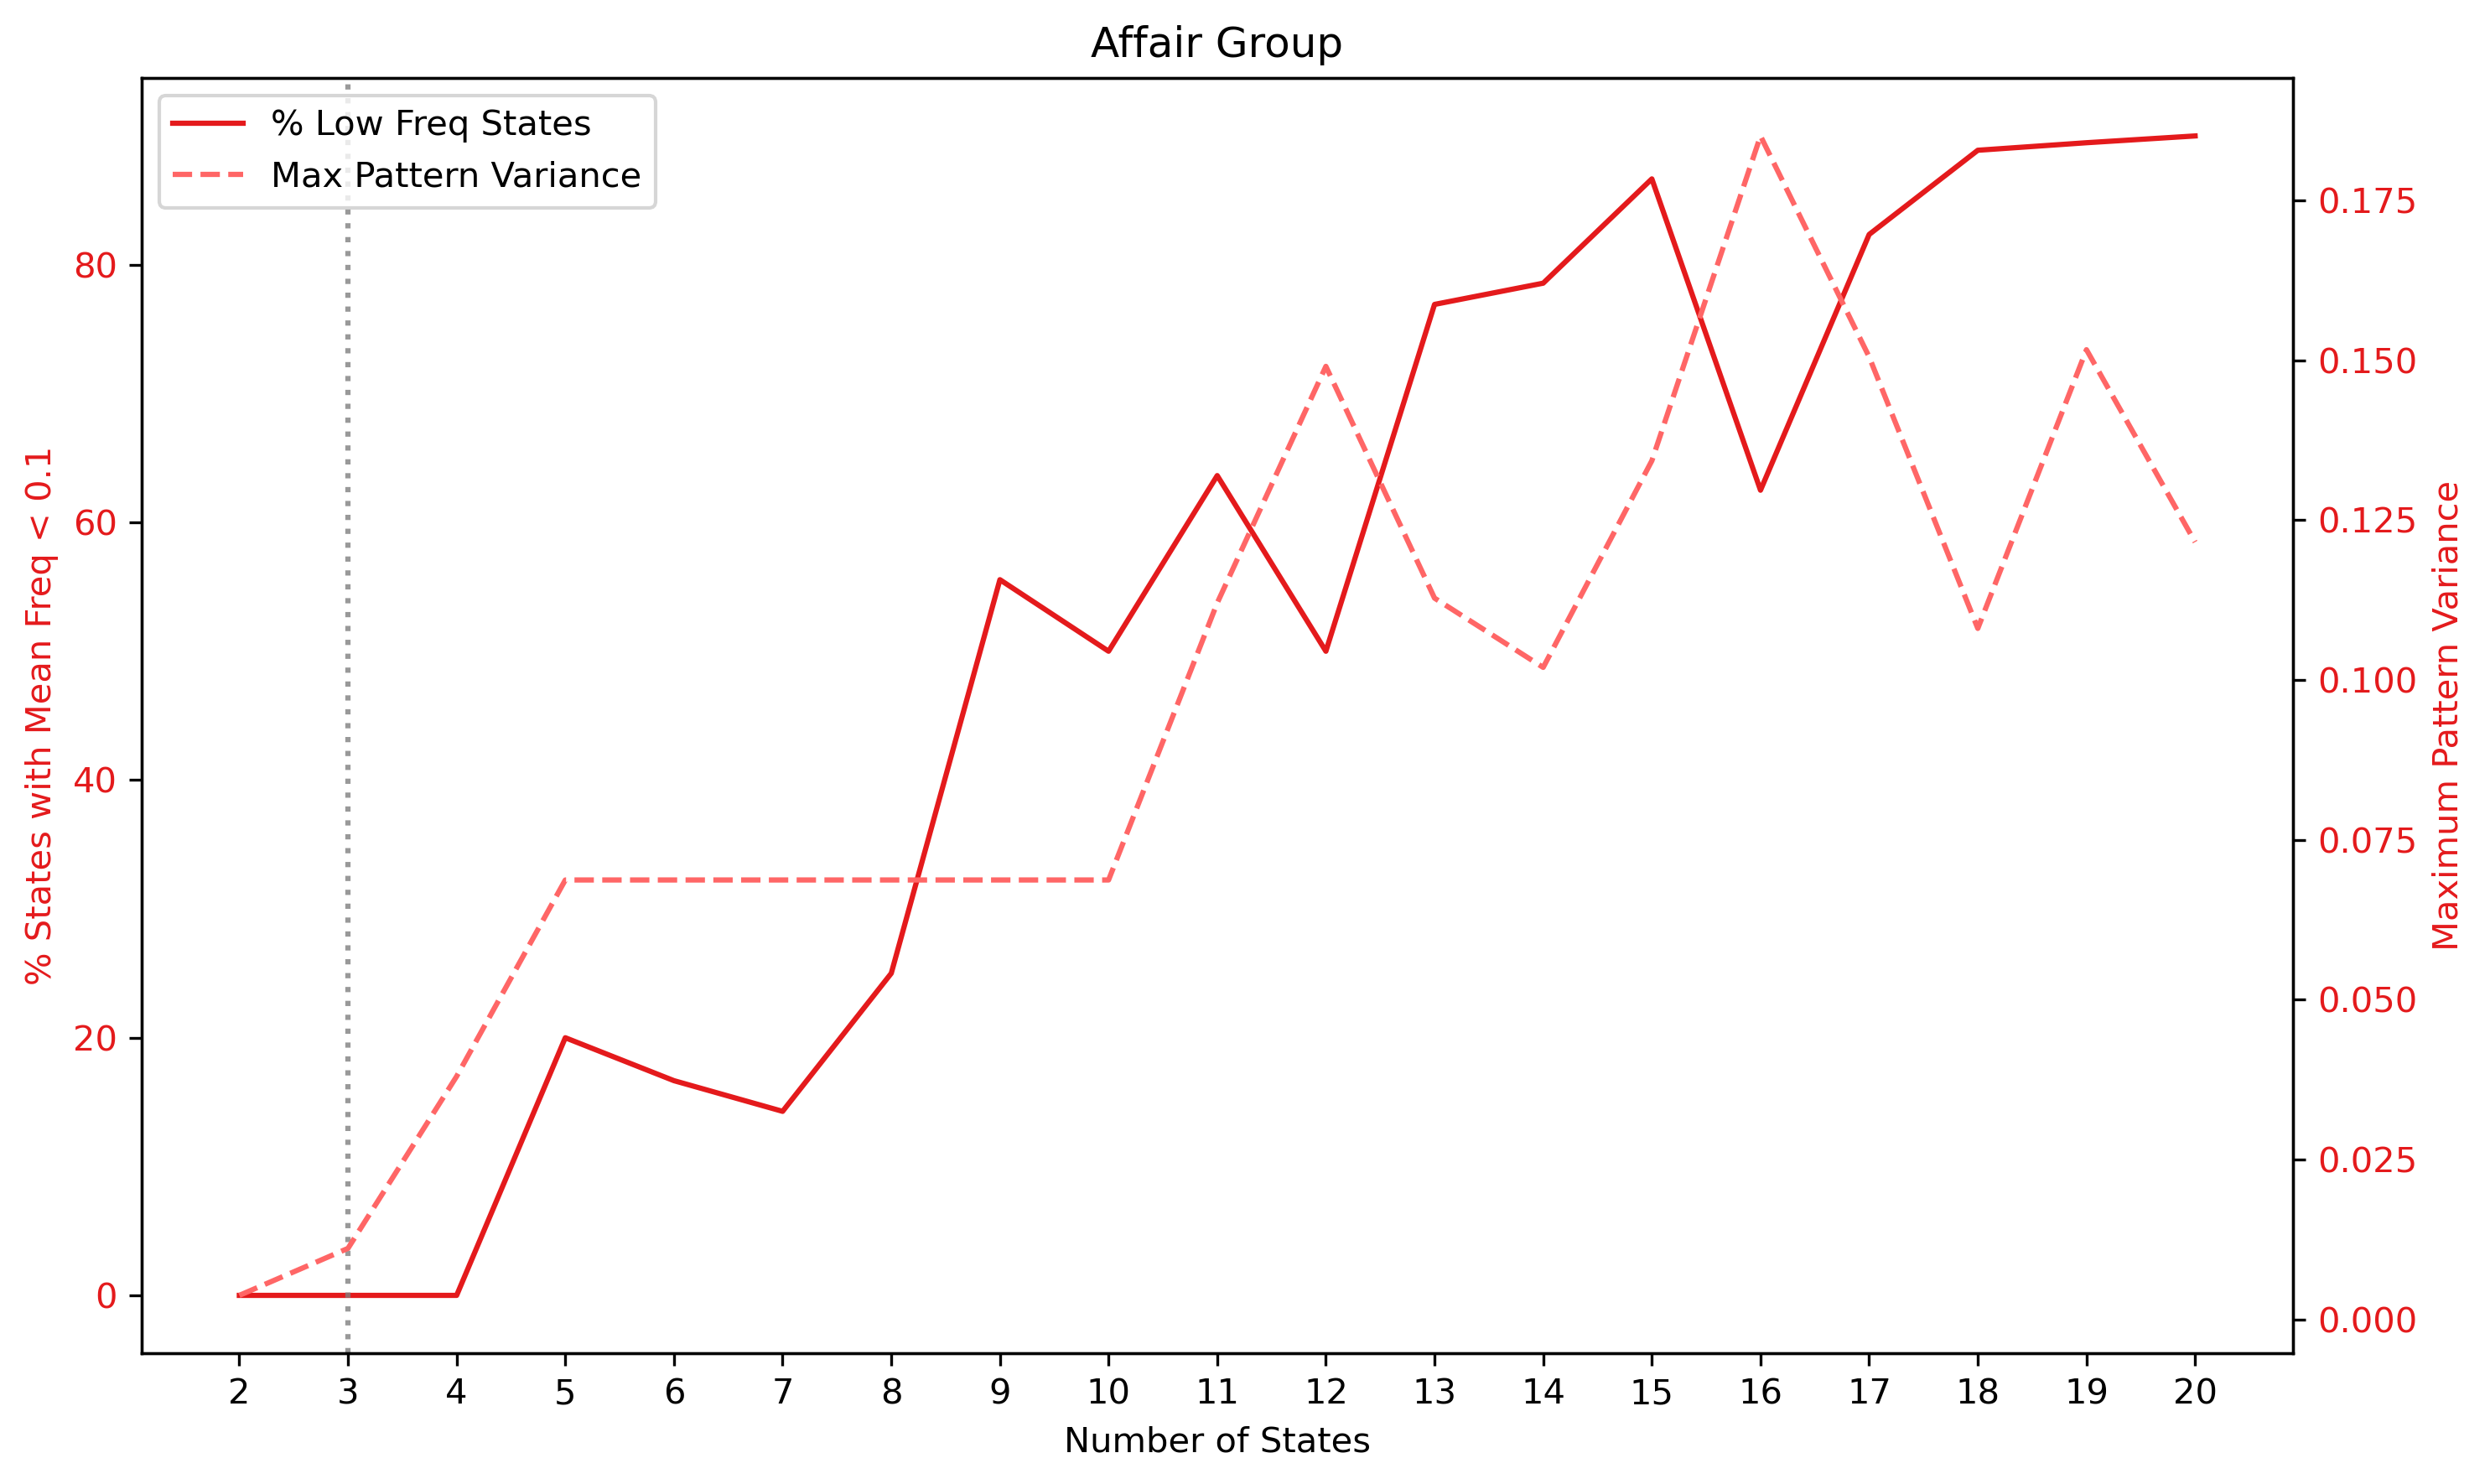

In [19]:
create_selection_plot('affair')

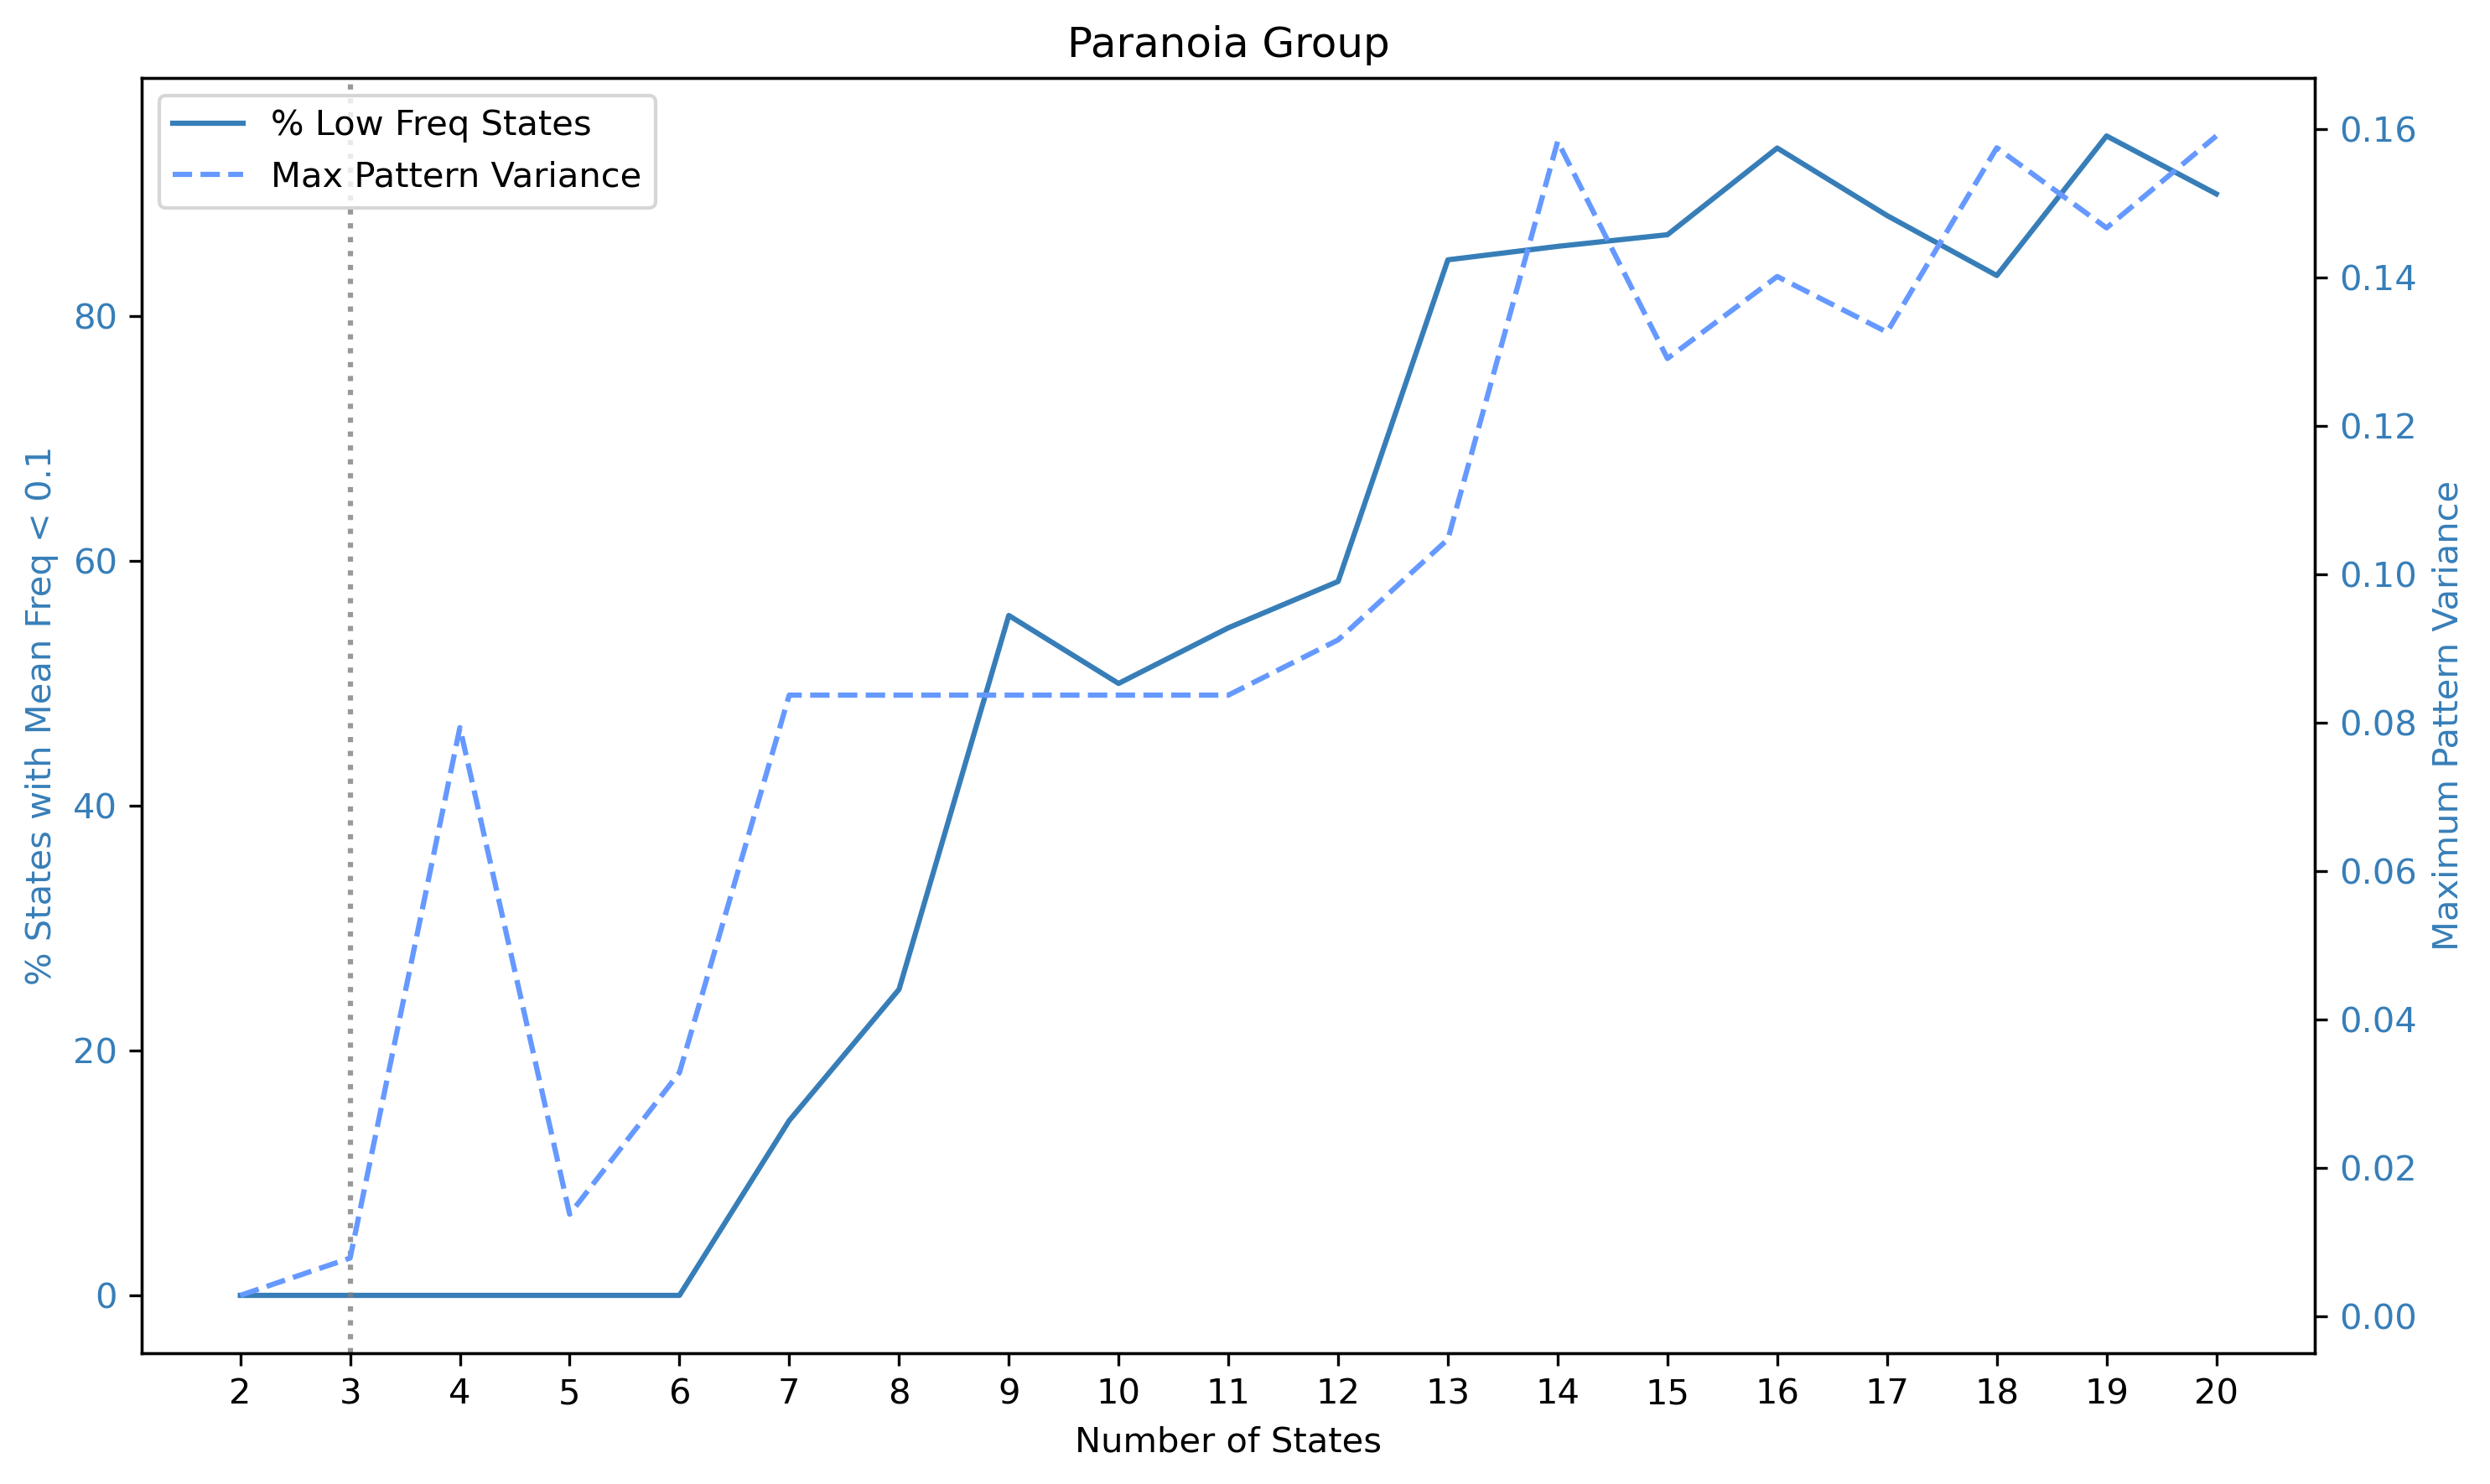

In [20]:
create_selection_plot('paranoia')


In [21]:
def create_model_comparison_plot():
    """Create plot comparing BIC and log-likelihood for both groups with dual y-axes."""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Create second y-axis
    ax2 = ax1.twinx()
    
    # Store lines for legend
    lines = []
    labels = []
    
    for group in GROUPS:
        data = []
        for n_state in N_STATES_RANGE:
            loaded_data = load_data(group, n_state)
            if loaded_data:
                metrics = extract_model_metrics(loaded_data)
                if metrics and 'bic' in metrics and 'log_likelihood' in metrics:
                    data.append({
                        'n_states': n_state,
                        'bic': metrics['bic'],
                        'log_likelihood': metrics['log_likelihood']
                    })
        
        if data:
            df = pd.DataFrame(data)
            
            # Plot BIC on left y-axis
            ln1 = ax1.plot(df['n_states'], df['bic'], 
                    color=COLORS[group], 
                    label=f'{group.capitalize()} BIC',
                    marker='o')
            lines.extend(ln1)
            labels.append(f'{group.capitalize()} BIC')
            
            # Plot Log-likelihood on right y-axis
            ln2 = ax2.plot(df['n_states'], df['log_likelihood'],
                    color=COLORS[f'{group}_light'],
                    label=f'{group.capitalize()} Log-Likelihood',
                    marker='o',
                    linestyle='--')
            lines.extend(ln2)
            labels.append(f'{group.capitalize()} Log-Likelihood')
    
    # Set x-axis to show all integer values
    ax1.set_xticks(list(N_STATES_RANGE))
    
    # Add vertical line at n_state=3
    ax1.axvline(x=3, color='gray', linestyle=':', alpha=0.5)
    
    # Labels and titles
    ax1.set_title('Model Comparison: BIC and Log-Likelihood')
    ax1.set_xlabel('Number of States')
    ax1.set_ylabel('BIC Score', color='black')
    ax2.set_ylabel('Log-Likelihood', color='black')
    
    # Color the tick labels
    ax1.tick_params(axis='y', colors='black')
    ax2.tick_params(axis='y', colors='black')
    
    # Combined legend
    ax1.legend(lines, labels, loc='center right')
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'model_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

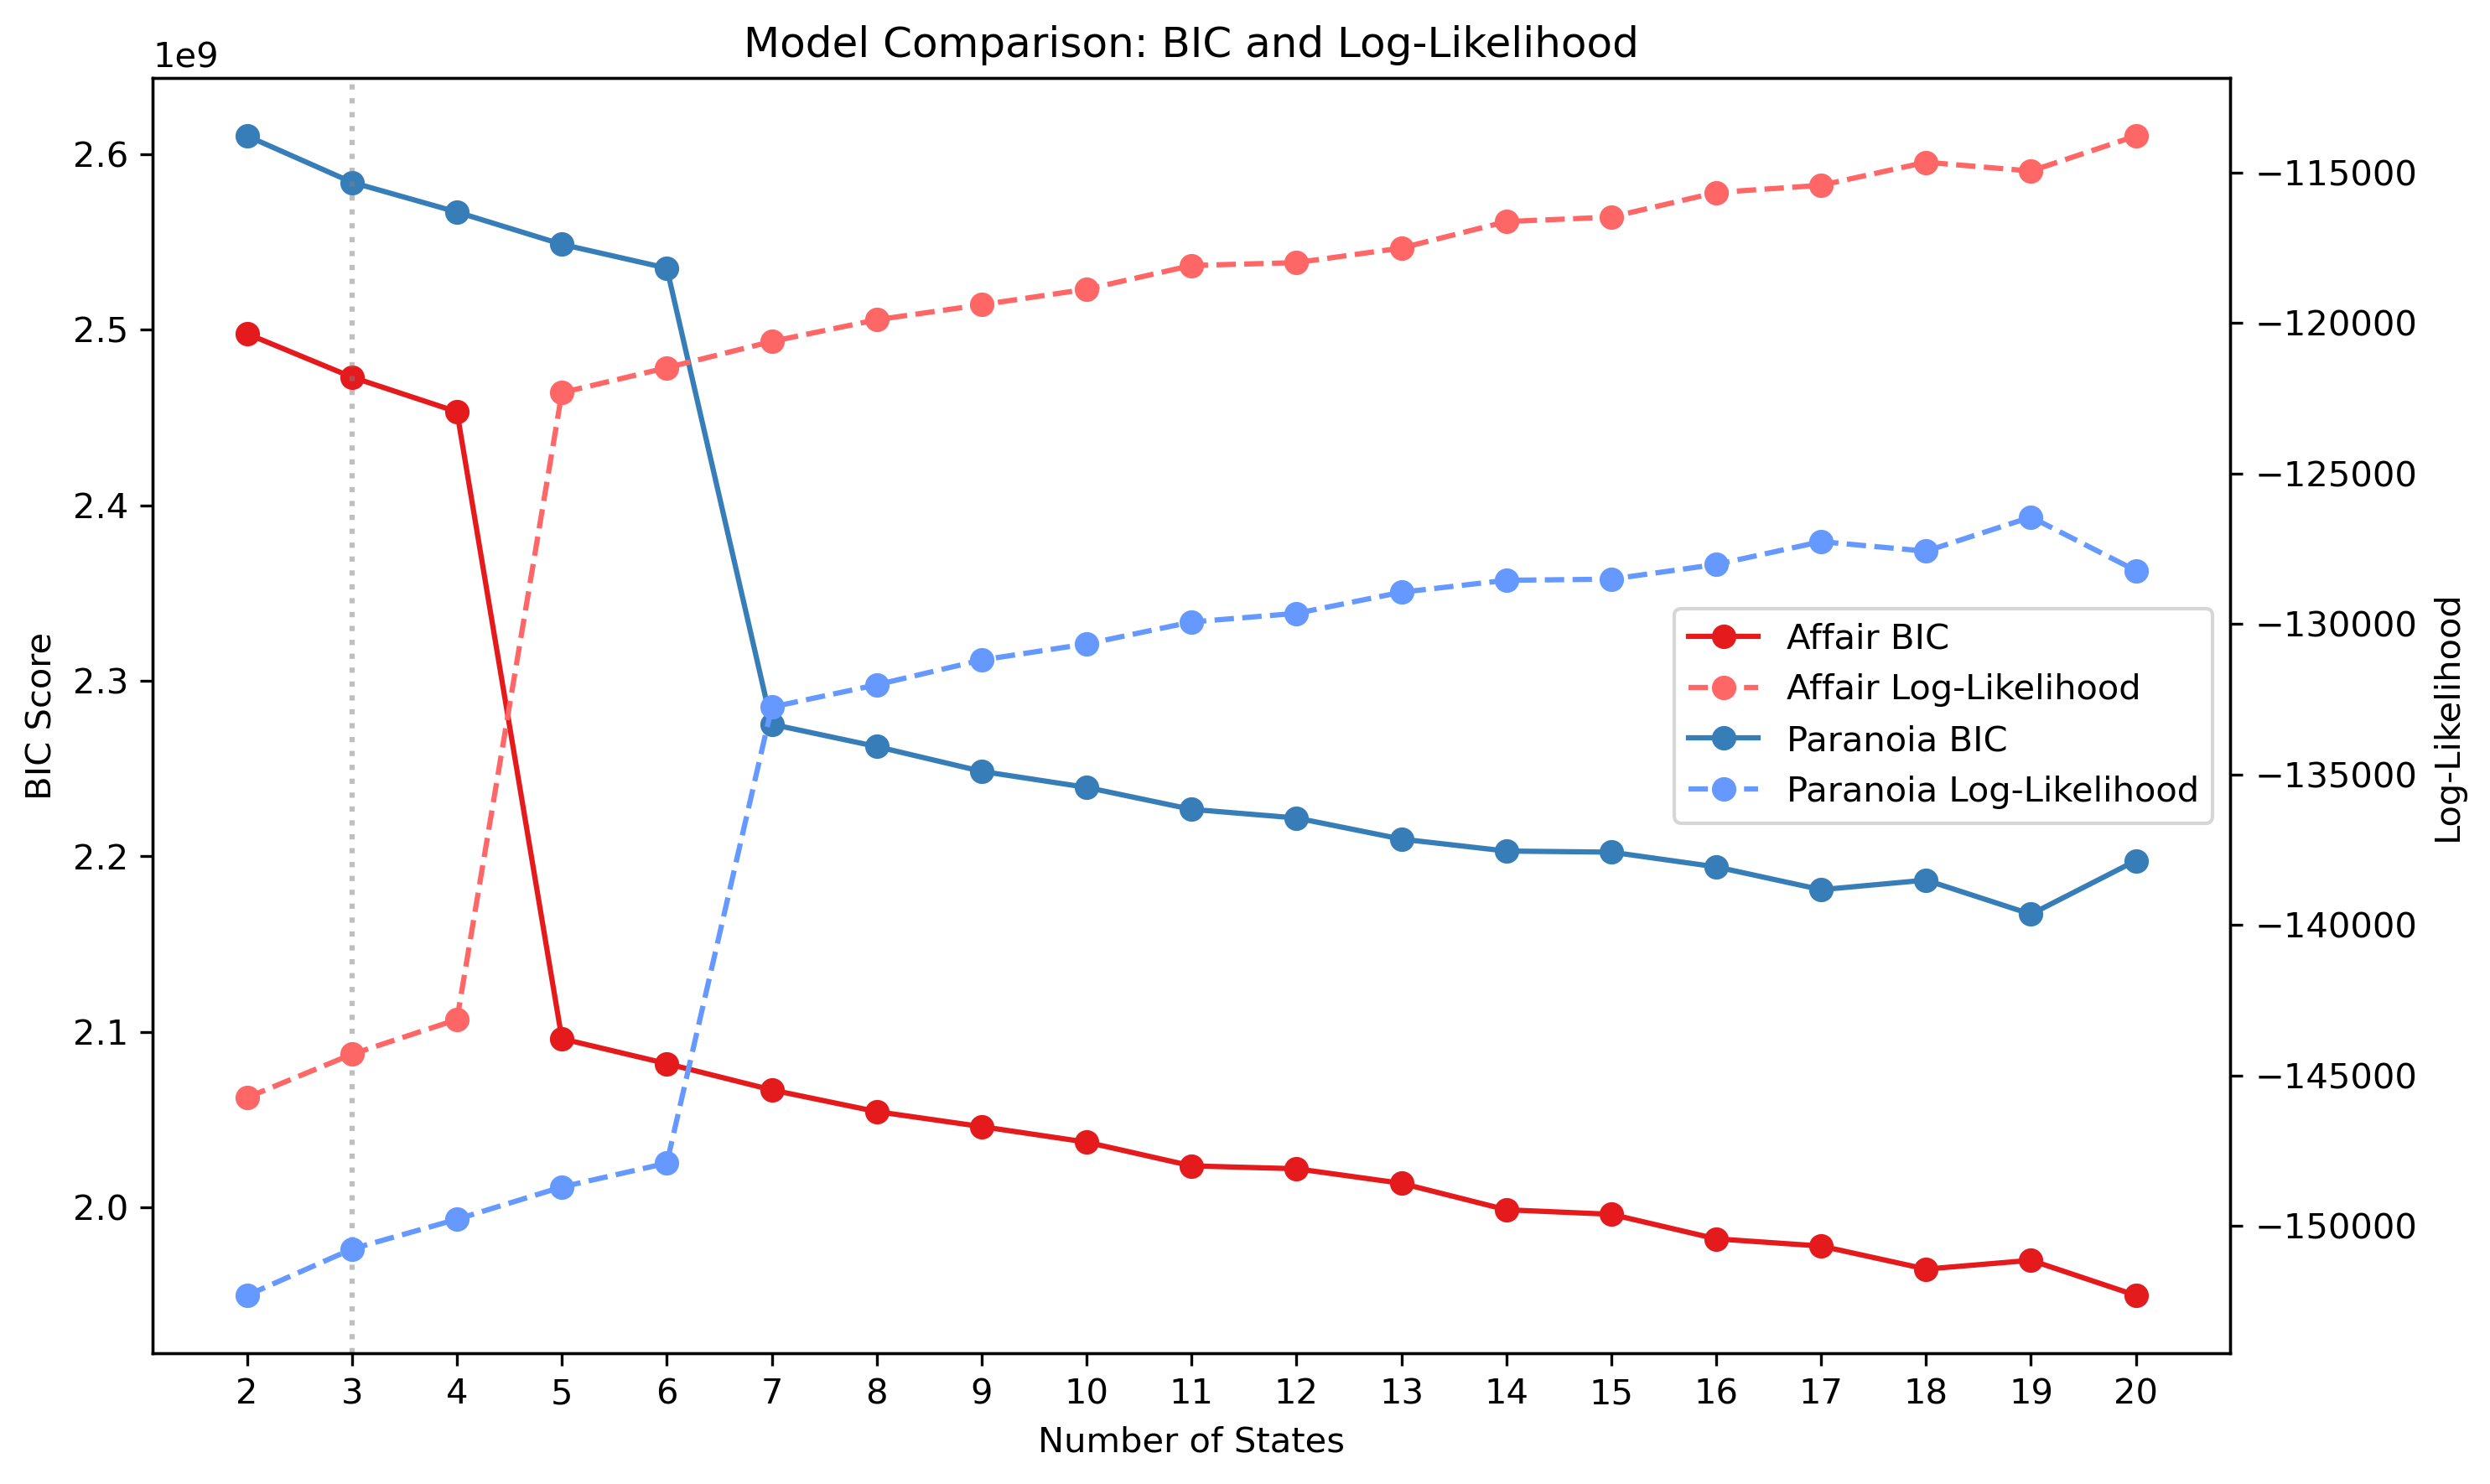

In [22]:
create_model_comparison_plot()

In [23]:
def create_stability_plot():
    """Create pattern stability comparison plot for both groups."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for group in GROUPS:
        data = []
        for n_state in N_STATES_RANGE:
            loaded_data = load_data(group, n_state)
            if loaded_data:
                metrics = extract_model_metrics(loaded_data)
                if metrics and 'mean_pattern_stability' in metrics:
                    data.append({
                        'n_states': n_state,
                        'stability': metrics['mean_pattern_stability']
                    })
        
        if data:
            df = pd.DataFrame(data)
            ax.plot(df['n_states'], df['stability'], 
                    color=COLORS[group], 
                    label=f'{group.capitalize()} Group',
                    marker='o')
    
    # Set x-axis to show all integer values
    ax.set_xticks(list(N_STATES_RANGE))
    
    ax.axvline(x=3, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Number of States')
    ax.set_ylabel('Mean Pattern Stability')
    ax.set_title('Model Comparison: Pattern Stability')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'pattern_stability.png', dpi=300, bbox_inches='tight')
    plt.close()

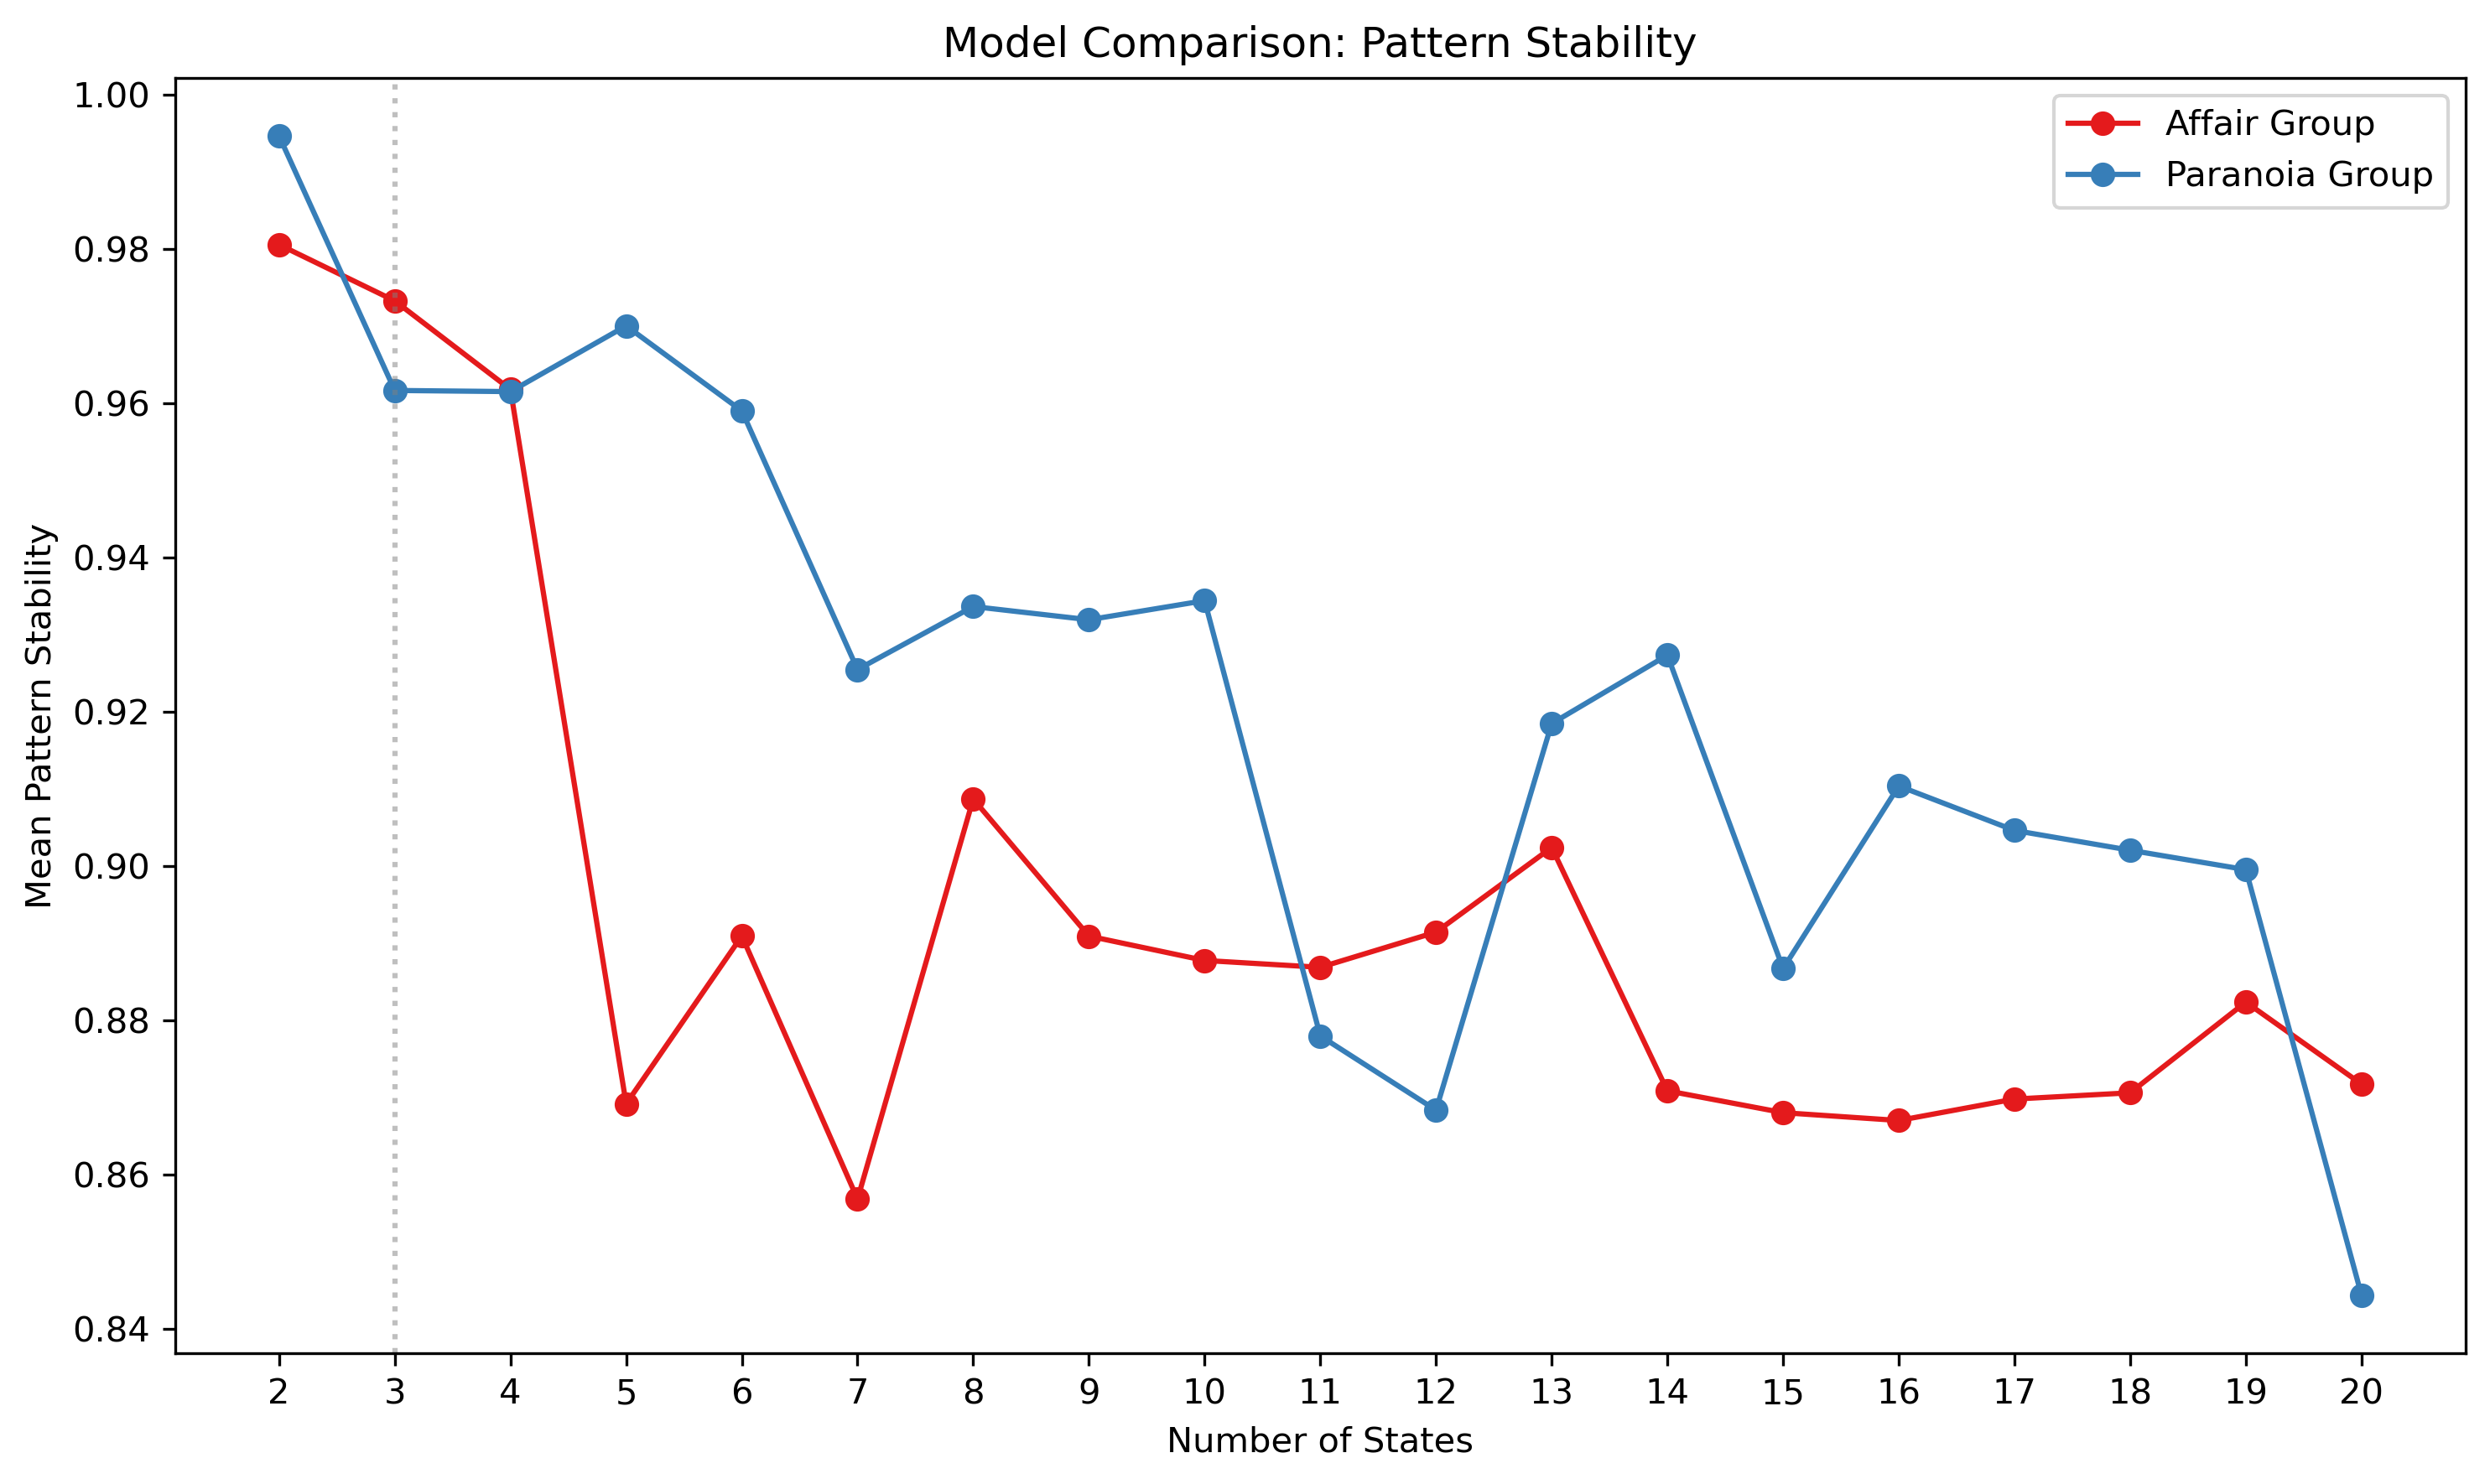

In [24]:
create_stability_plot()

### 2.3

In [25]:
# Load the saved results
with open(OUTPUT_DIR / "09_group_HMM_comparison" / "comparisons.pkl", 'rb') as f:
    results = pickle.load(f)


In [29]:
def plot_similarity():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sim_matrix = results['state_similarity']['similarity_matrix']
    matched_states = results['state_similarity']['matched_states']
    
    # Create heatmap
    sns.heatmap(sim_matrix,
                annot=True,
                cmap='viridis',
                vmin=0,
                vmax=1,
                fmt='.2f',
                ax=ax,
                xticklabels=['S1', 'S2', 'S3'],
                yticklabels=['S1', 'S2', 'S3'])
    
    # Mark matched states with red rectangles
    for i, j in matched_states:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,
                                 edgecolor='red', lw=2))
    
    ax.set_title('State Pattern Similarity', pad=20)
    ax.set_xlabel('Paranoia')
    ax.set_ylabel('Affair')
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'state_similarity.png', dpi=300, bbox_inches='tight')
    plt.close()

# Plot 2: Temporal Dynamics
def plot_temporal_dynamics():
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    matched_states = results['state_similarity']['matched_states']
    temporal_data = results['temporal_dynamics']
    
    for idx, (affair_idx, paranoia_idx) in enumerate(matched_states):
        ax = axes[idx]
        key = f'state_pair_{affair_idx}_{paranoia_idx}'
        profile = temporal_data[key]['temporal_profile']
        
        # Plot affair profile
        ax.plot(profile['affair_profile'],
               color=COLORS['affair'],
               label='Affair',
               linewidth=2)
        
        # Plot paranoia profile
        ax.plot(profile['paranoia_profile'],
               color=COLORS['paranoia'],
               label='Paranoia Reordered',
               linewidth=2,
               linestyle='--')
        
        ax.set_title(f'State {idx+1}')
        
        # Only show x-axis labels for the bottom plot
        if idx < 2:
            ax.set_xticks([])
        else:
            ax.set_xlabel('Time (TRs)')
        
        ax.set_ylabel('State Probability')
        ax.legend()
        
        # Set y-axis limits
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'temporal_dynamics.png', dpi=300, bbox_inches='tight')
    plt.close()

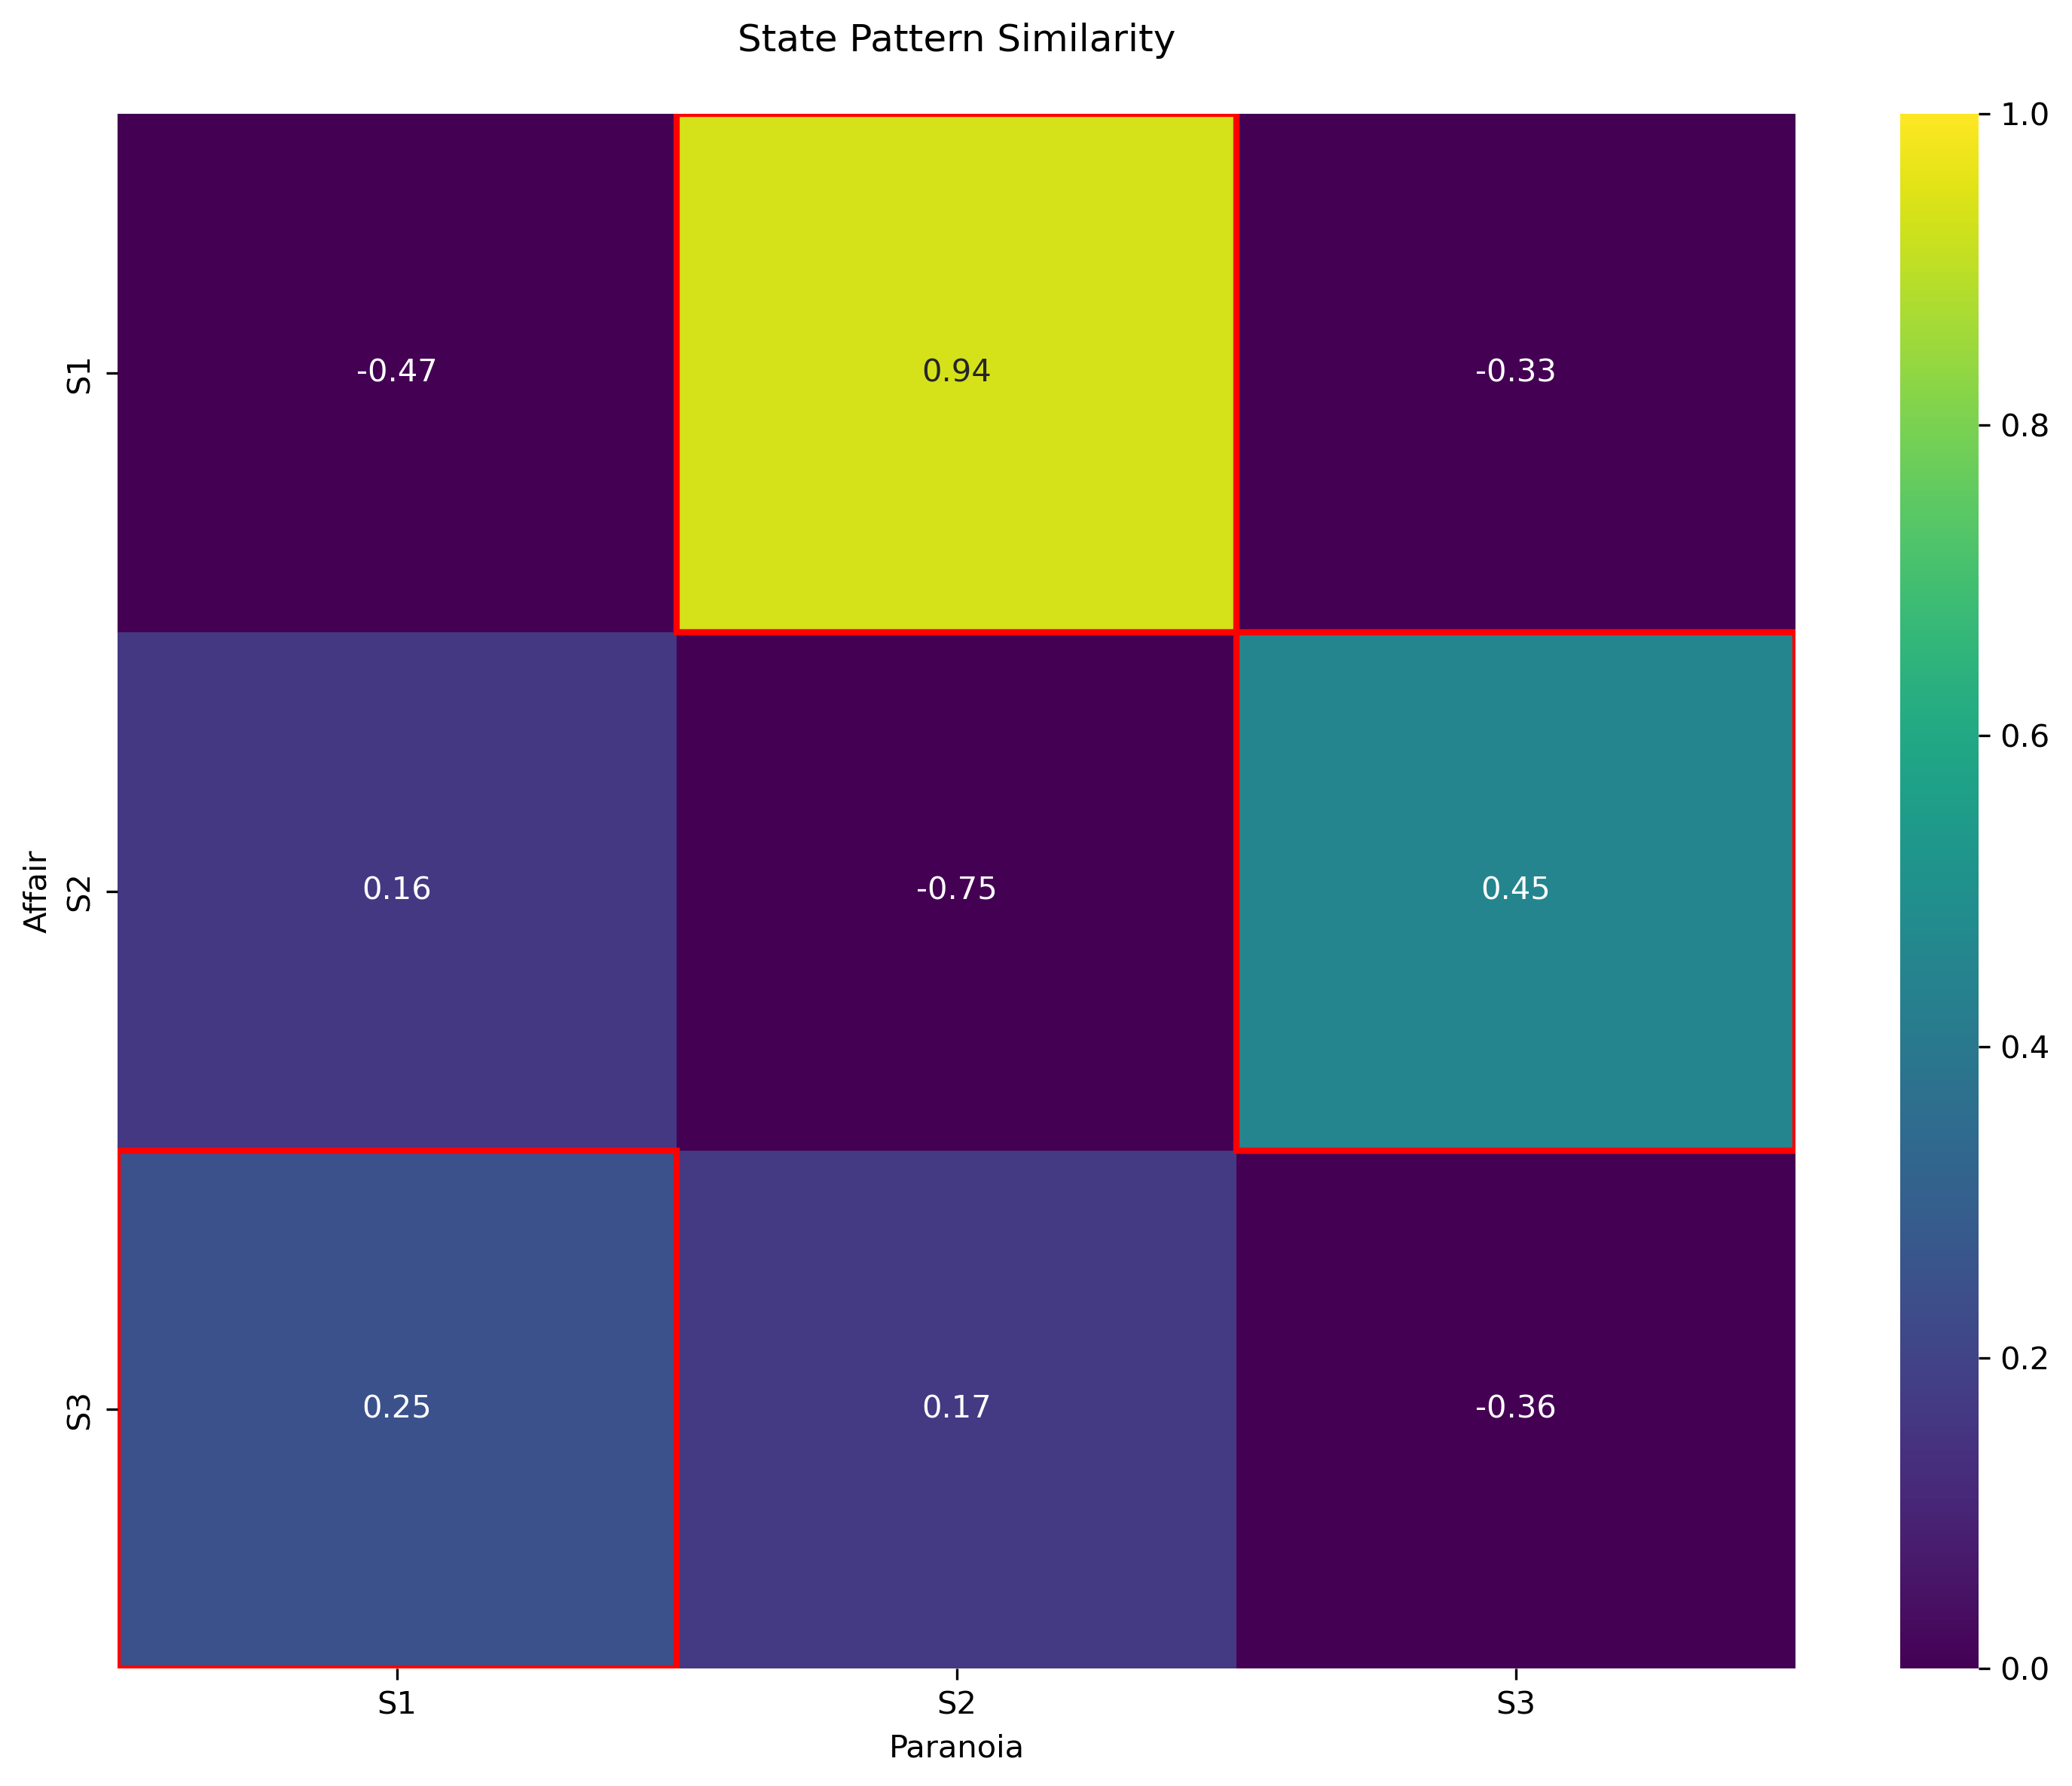

In [30]:
plot_similarity()

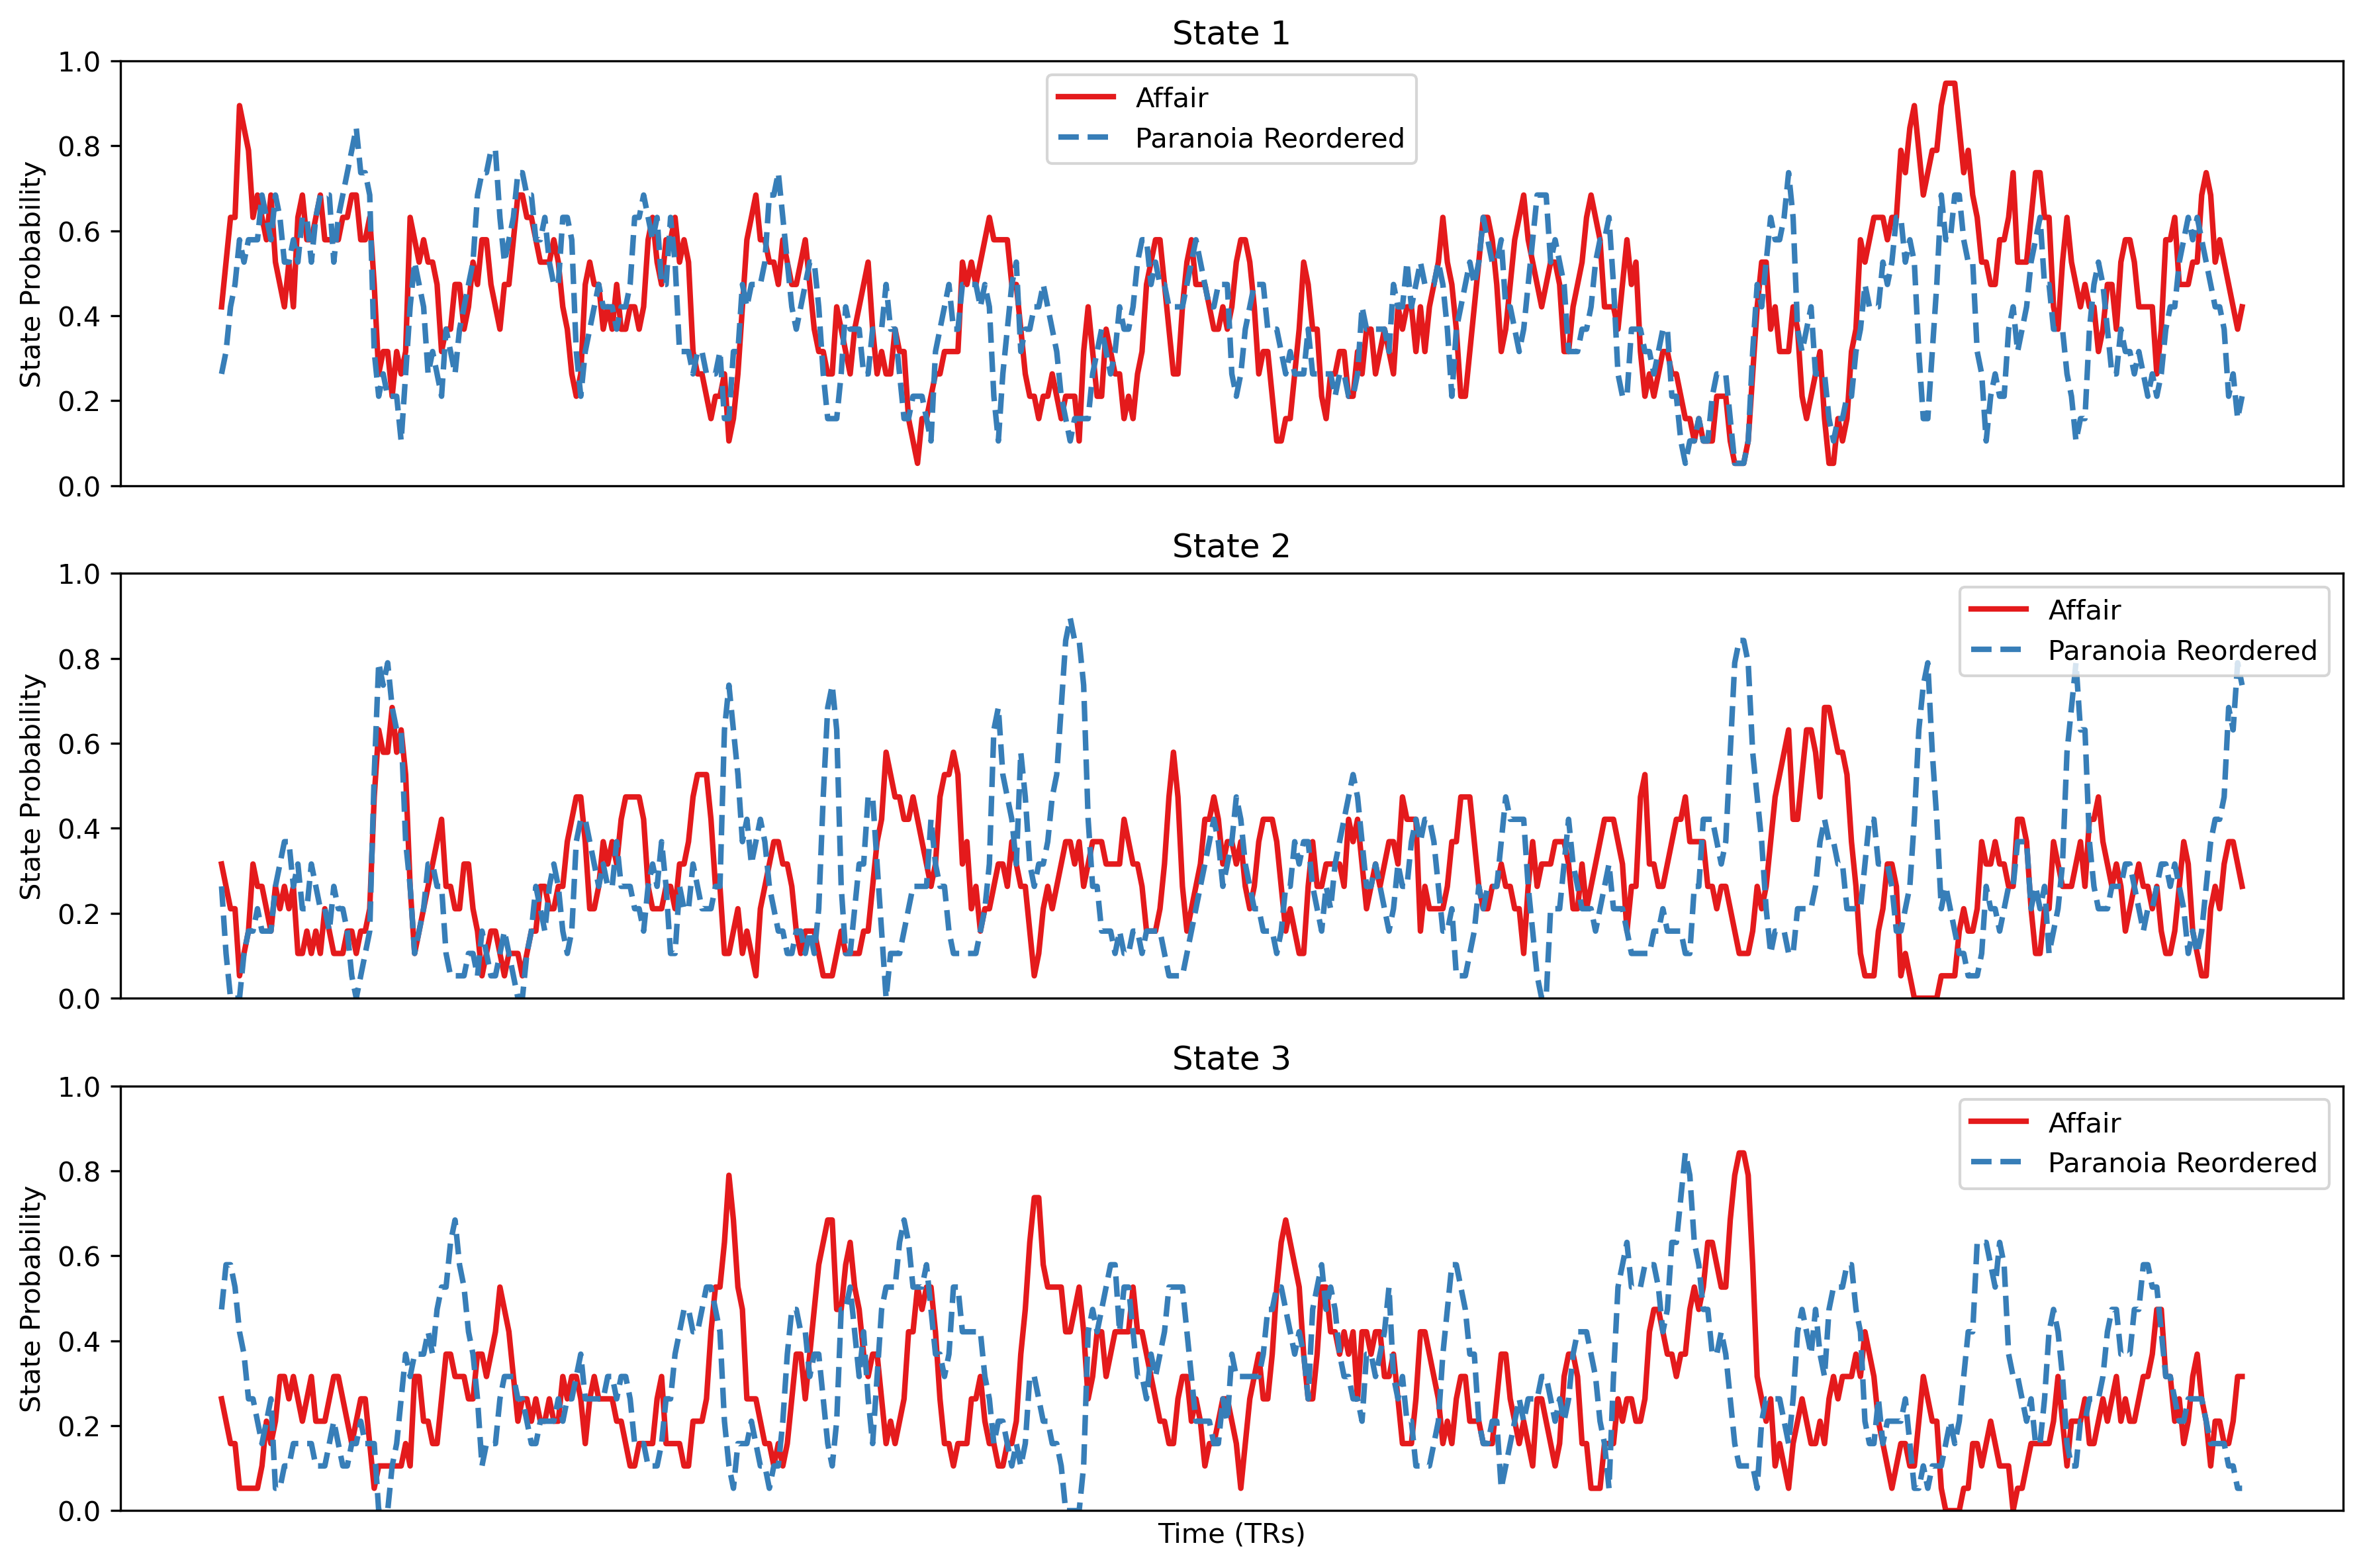

In [31]:
plot_temporal_dynamics()


## Figure 3

In [4]:
SAVE_DIR_FIG3 = Path(SAVE_DIR) / "figure3"
SAVE_DIR_FIG3.mkdir(parents=True, exist_ok=True)

In [5]:
def save_figure(fig, filename, dpi=300, bbox_inches='tight'):
    fig.savefig(Path(SAVE_DIR_FIG3) / filename, dpi=dpi, bbox_inches=bbox_inches)
    plt.close(fig)

### 3.1

In [34]:
def create_raster_plot(annotations_file: str, grouped: bool = False) -> plt.Figure:
    """Create raster plot of story features."""
    df = pd.read_csv(annotations_file)
    df['onset'] = df['onset'] - df['onset'].min()
    
    if not grouped:
        features = ['is_dialog', 'arthur_speaking', 'lee_speaking', 
                   'girl_speaking', 'lee_girl_together', 'is_verb', 
                   'is_noun', 'is_adj', 'is_adv']
        colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', 
                 '#F39B7F', '#8491B4', '#91D1C2', '#DC0000', '#7E6148']
        
        fig, ax = plt.subplots(figsize=(20, 6))
        
        for idx, (feature, color) in enumerate(zip(features, colors)):
            mask = df[feature].astype(bool)
            if mask.any():
                ax.vlines(df.loc[mask, 'onset'], 
                         idx - 0.2, idx + 0.2,
                         color=color, linewidth=2)
        
        ax.set_yticks(range(len(features)))
        ax.set_yticklabels([f.replace('_', ' ').title() for f in features])
        ax.set_xlim(0, df['onset'].max())
        
    else:
        speaker_features = ['arthur_speaking', 'lee_speaking', 'girl_speaking', 'lee_girl_together']
        pos_features = ['is_verb', 'is_noun', 'is_adj', 'is_adv']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), height_ratios=[1, 1])
        
        # Speaker features
        colors1 = ['#4DBBD5', '#00A087', '#3C5488', '#F39B7F']
        for idx, (feature, color) in enumerate(zip(speaker_features, colors1)):
            mask = df[feature].astype(bool)
            if mask.any():
                ax1.vlines(df.loc[mask, 'onset'], 
                          idx - 0.2, idx + 0.2,
                          color=color, linewidth=2)
        
        # POS features
        colors2 = ['#8491B4', '#91D1C2', '#DC0000', '#7E6148']
        for idx, (feature, color) in enumerate(zip(pos_features, colors2)):
            mask = df[feature].astype(bool)
            if mask.any():
                ax2.vlines(df.loc[mask, 'onset'], 
                          idx - 0.2, idx + 0.2,
                          color=color, linewidth=2)
        
        for ax, features, title in [(ax1, speaker_features, 'Speaker Features'),
                                  (ax2, pos_features, 'Part of Speech Features')]:
            ax.set_yticks(range(len(features)))
            ax.set_yticklabels([f.replace('_', ' ').title() for f in features])
            ax.set_xlim(0, df['onset'].max())
            ax.set_title(title)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.grid(True, axis='x', alpha=0.3)
            
        ax2.set_xlabel('Time (seconds)')
    
    if not grouped:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.grid(True, axis='x', alpha=0.3)
        ax.set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    return fig



In [35]:
data_dir = os.path.join(scratch_dir, 'data', 'stimuli')
file = Path(data_dir) / "10_story_annotations.csv"

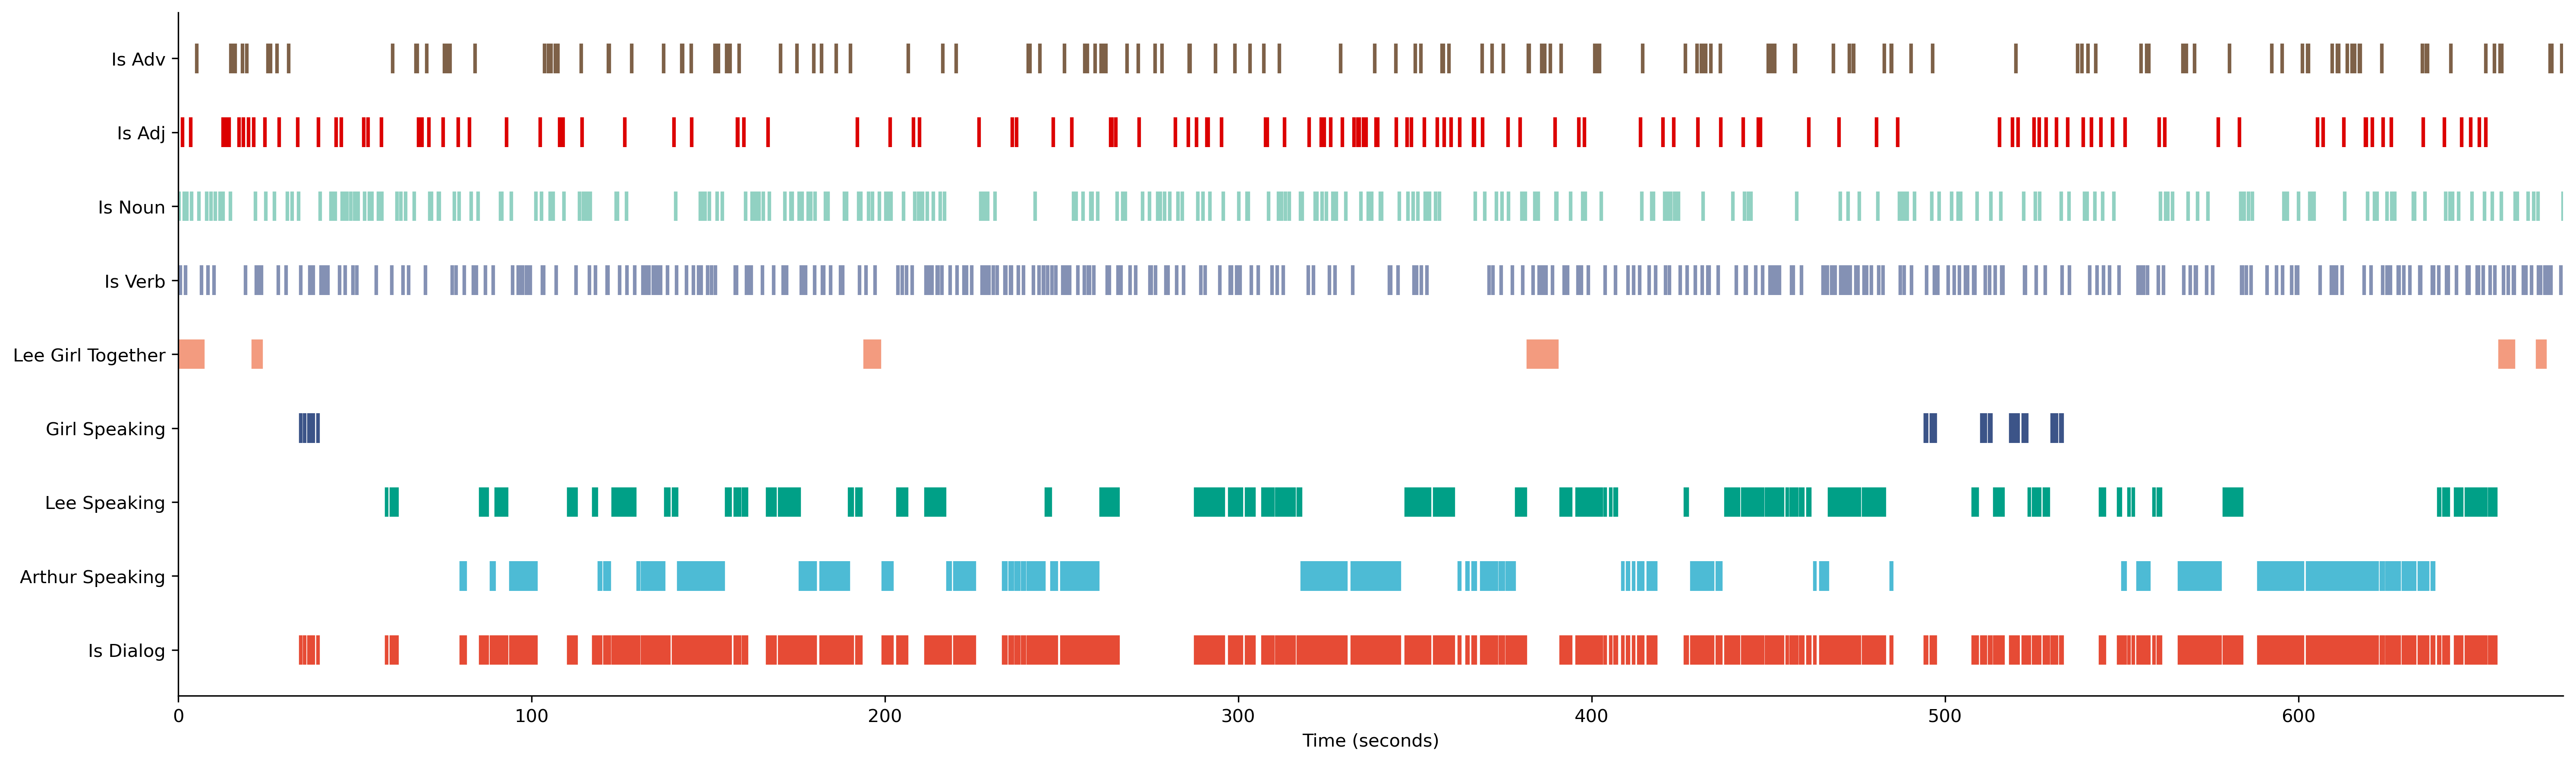

In [36]:
fig1 = create_raster_plot(file, grouped=False)
fig1

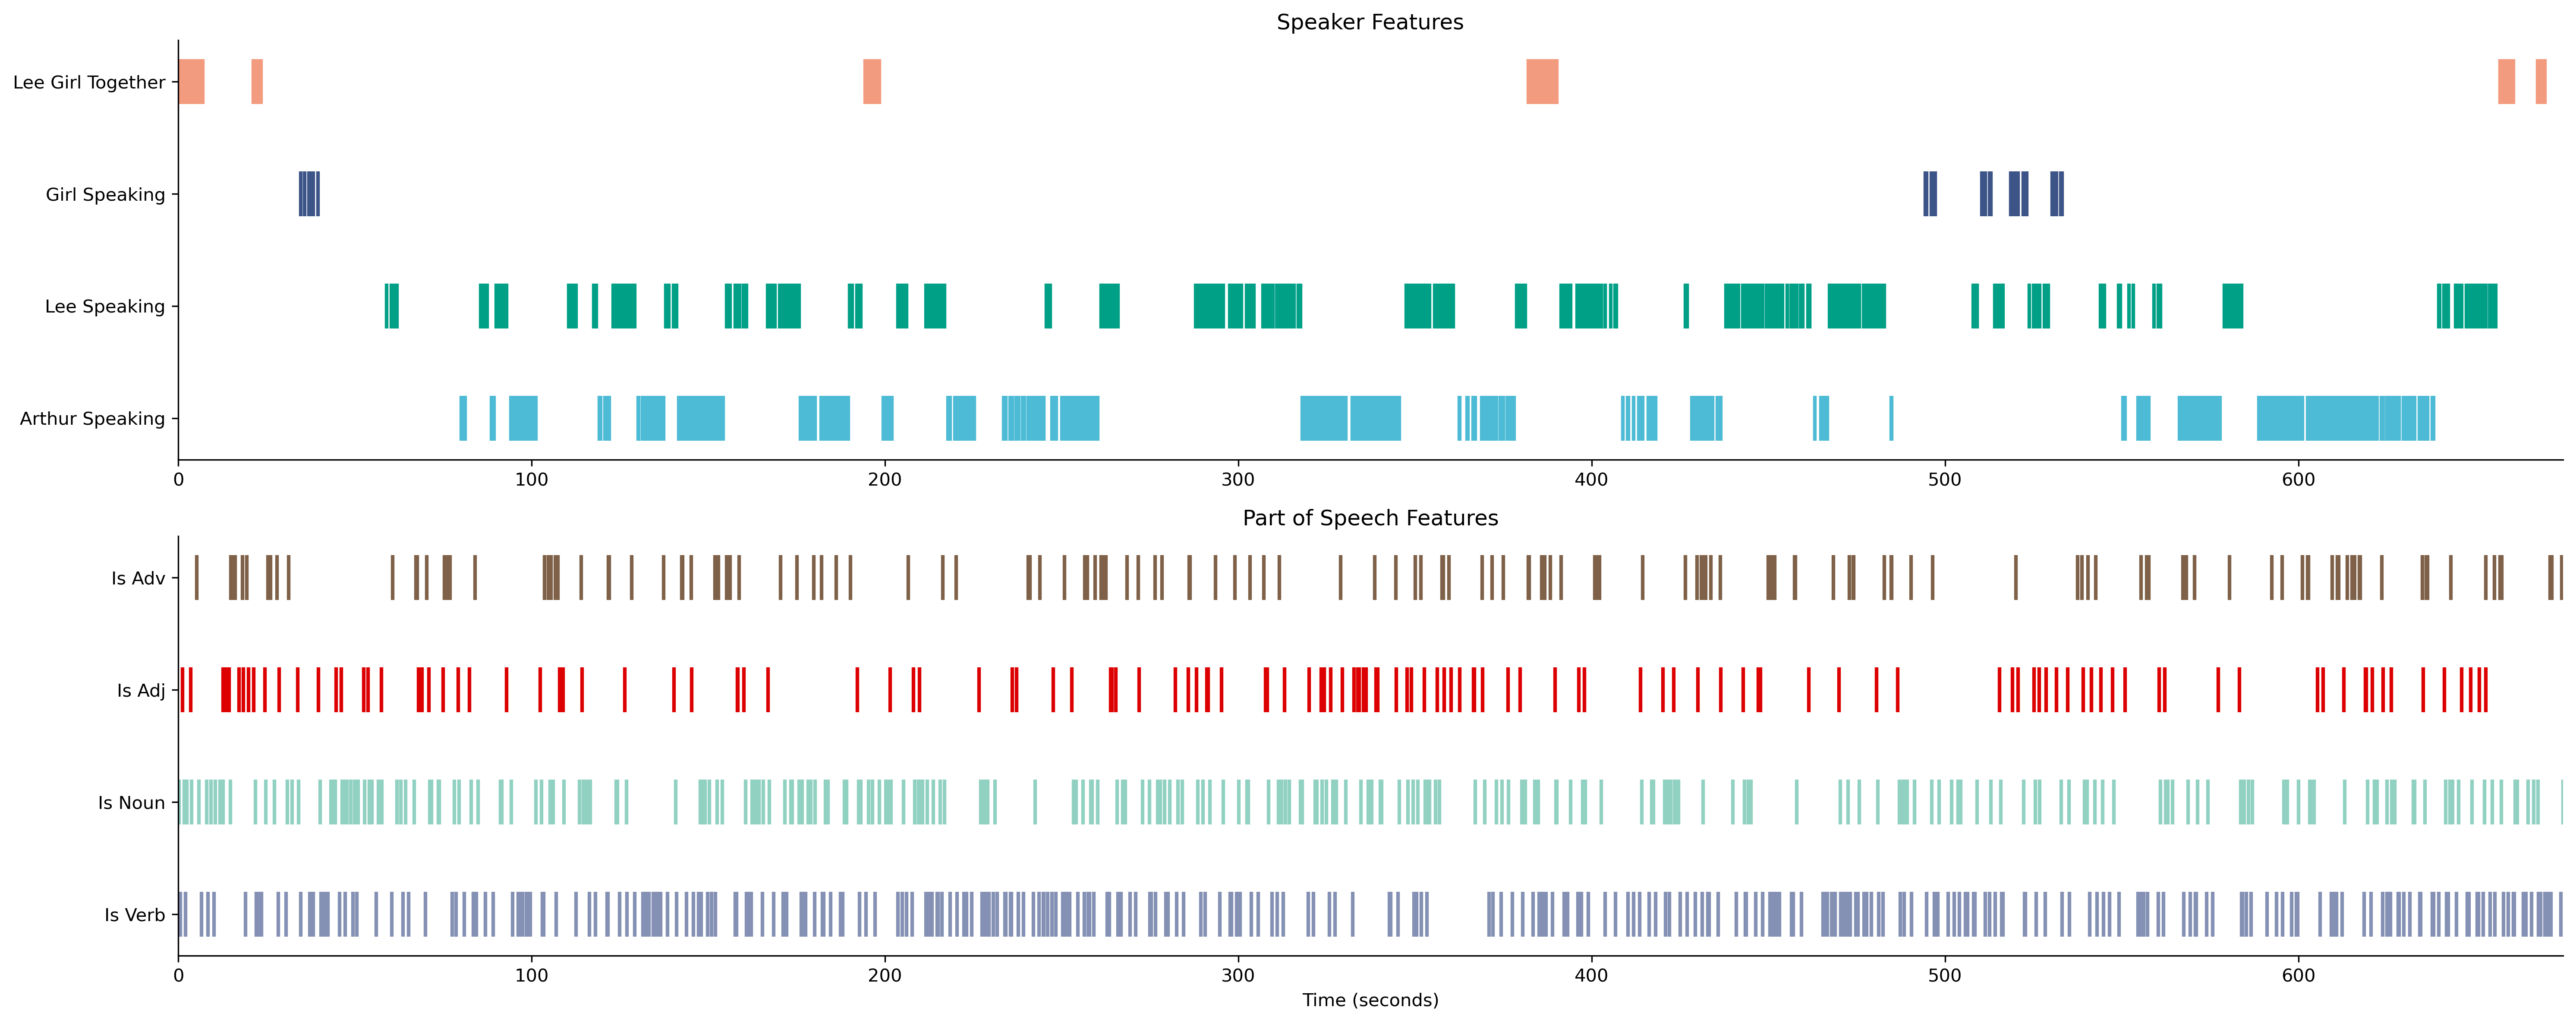

In [37]:
fig2 = create_raster_plot(file, grouped=True)
fig2

In [38]:
save_figure(fig1, 'figure3_panel1_all_features.png')
save_figure(fig2, 'figure3_panel1_grouped.png')

In [39]:
def create_tr_raster_plot(annotations_file: str) -> plt.Figure:
    """Create raster plot of story features at TR level."""
    # Read data
    df = pd.read_csv(annotations_file)
    
    # Binary features and count features
    binary_features = ['is_dialog', 'arthur_speaking', 'lee_speaking', 
                      'girl_speaking', 'lee_girl_together', 
                      'has_verb', 'has_noun', 'has_adj', 'has_adv']
    count_features = ['n_verb', 'n_noun', 'n_adj', 'n_adv']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), height_ratios=[2, 1])
    
    # Colors for binary features
    colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', 
             '#F39B7F', '#8491B4', '#91D1C2', '#DC0000', '#7E6148']
    
    # Plot binary features
    for idx, (feature, color) in enumerate(zip(binary_features, colors)):
        mask = df[feature].astype(bool)
        if mask.any():
            ax1.vlines(df.loc[mask, 'adjusted_onset_TR'], 
                      idx - 0.2, idx + 0.2,
                      color=color, linewidth=2)
    
    # # Add segment onset vertical lines
    # unique_segments = df['segment_onset'].unique()
    # for onset in unique_segments:
    #     if pd.notna(onset):
    #         tr_onset = df[df['segment_onset'] == onset]['adjusted_onset_TR'].iloc[0]/1.5
    #         ax1.axvline(x=tr_onset, color='gray', alpha=0.3, linestyle='--', zorder=0)
    #         ax2.axvline(x=tr_onset, color='gray', alpha=0.3, linestyle='--', zorder=0)
    
    # Plot count features
    for idx, feature in enumerate(count_features):
        counts = df[feature]
        if counts.max() > 0:
            # Normalize counts for visualization
            normalized_counts = counts / counts.max()
            ax2.vlines(df['adjusted_onset_TR'], 
                      idx - 0.1 + normalized_counts * 0.4, 
                      idx - 0.1,
                      color=colors[idx+5], linewidth=2)
    
    # Customize binary features plot
    ax1.set_yticks(range(len(binary_features)))
    ax1.set_yticklabels([f.replace('_', ' ').title() for f in binary_features])
    ax1.set_xlim(0, df['adjusted_onset_TR'].max())
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # ax1.grid(True, axis='x', alpha=0.3)
    ax1.set_title('Binary Features', pad=10)
    
    # Customize count features plot
    ax2.set_yticks(range(len(count_features)))
    ax2.set_yticklabels([f.replace('n_', '# ').replace('_', ' ').title() for f in count_features])
    ax2.set_xlim(0, df['adjusted_onset_TR'].max())
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    # ax2.grid(True, axis='x', alpha=0.3)
    ax2.set_xlabel('Time (TR)')
    ax2.set_title('Count Features', pad=10)
    
    plt.tight_layout()
    return fig

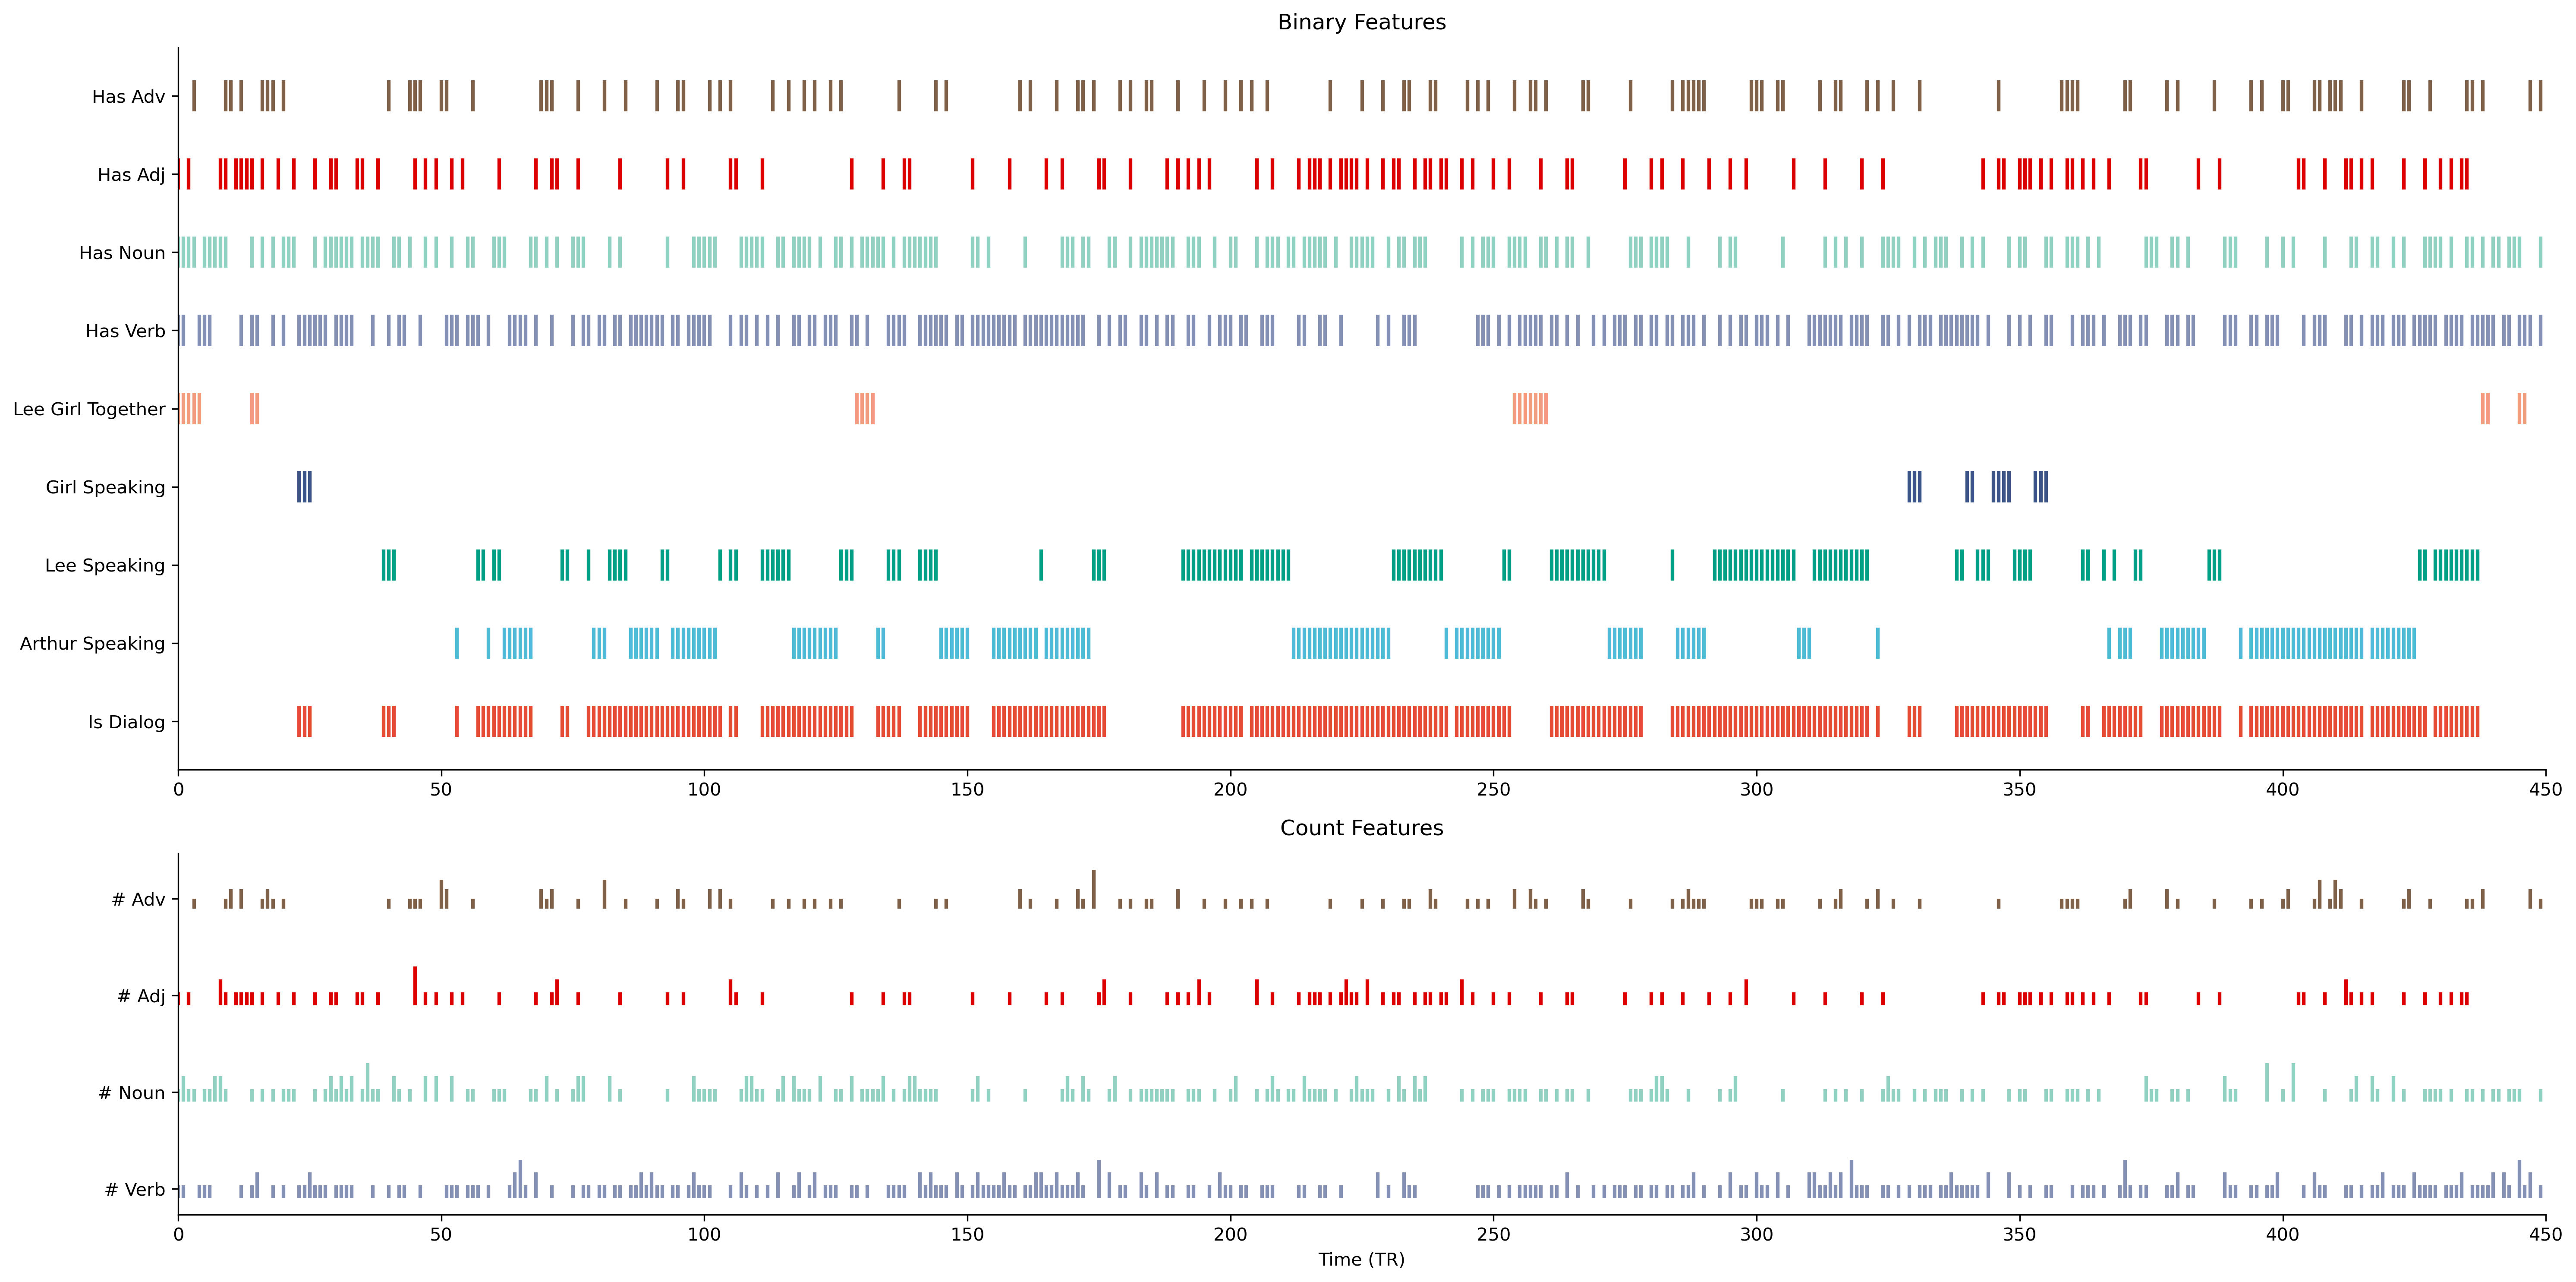

In [40]:
# Create plot
fig3 = create_tr_raster_plot(Path(data_dir) / '10_story_annotations_TR.csv')
fig3


In [41]:
save_figure(fig3, 'figure3_panel1_tr_level.png')

### 3.2

In [6]:
brain_content_path = Path(OUTPUT_DIR) / '11_brain_content_analysis' / 'hierarchical_analysis_results_2025-02-17_15-19-53.npz'
brain_content_data = np.load(brain_content_path, allow_pickle=True)
meta_data = brain_content_data['metadata']
main_analysis = brain_content_data['main_analysis']
cross_validation = brain_content_data['cross_validation']

In [13]:
def plot_brain_state_effects(main_analysis):
    """
    Create a plot showing main effects, group effects, and interaction effects
    for brain state analysis.
    
    Parameters:
    -----------
    main_analysis : numpy.ndarray
        Array containing feature_results with coefficients and p-values
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    # Convert numpy array to dictionary
    results_dict = main_analysis.item()
    
    # Extract features and effects
    features = []
    main_effects = []
    group_effects = []
    interaction_effects = []
    main_pvals = []
    group_pvals = []
    interaction_pvals = []
    
    for feature, results in results_dict['feature_results'].items():
        features.append(feature)
        # Extract coefficients
        main_effects.append(results['coefficients']['feature'])
        group_effects.append(results['coefficients']['group'])
        interaction_effects.append(results['coefficients']['interaction'])
        # Extract p-values
        main_pvals.append(results['pvalues']['feature'])
        group_pvals.append(results['pvalues']['group'])
        interaction_pvals.append(results['pvalues']['interaction'])
    
    # Convert to numpy arrays
    main_effects = np.array(main_effects)
    group_effects = np.array(group_effects)
    interaction_effects = np.array(interaction_effects)
    
    # Function to convert p-values to stars
    def get_significance_stars(p_val):
        if p_val < 0.001:
            return '***'
        elif p_val < 0.01:
            return '**'
        elif p_val < 0.05:
            return '*'
        return ''
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate y positions for each feature
    n_features = len(features)
    feature_positions = np.arange(n_features) * 3
    bar_width = 0.9
    
    # Plot bars
    main_bars = ax.barh(feature_positions - bar_width, main_effects, 
                        height=bar_width, color='purple', alpha=0.6, 
                        label='Main Effect')
    group_bars = ax.barh(feature_positions, group_effects, 
                         height=bar_width, color='blue', alpha=0.6,
                         label='Group Effect')
    interaction_bars = ax.barh(feature_positions + bar_width, interaction_effects, 
                              height=bar_width, color='green', alpha=0.6,
                              label='Interaction Effect')
    
    # Add significance stars
    for i, (main_p, group_p, int_p) in enumerate(zip(main_pvals, group_pvals, interaction_pvals)):
        # Main effect stars
        if main_effects[i] < 0:
            x_pos = main_effects[i] - 0.005
            ha = 'right'
        else:
            x_pos = main_effects[i] + 0.005
            ha = 'left'
        ax.text(x_pos, feature_positions[i] - bar_width, 
                get_significance_stars(main_p),
                va='center', ha=ha)
        
        # Group effect stars
        if group_effects[i] < 0:
            x_pos = group_effects[i] - 0.005
            ha = 'right'
        else:
            x_pos = group_effects[i] + 0.005
            ha = 'left'
        ax.text(x_pos, feature_positions[i],
                get_significance_stars(group_p),
                va='center', ha=ha)
        
        # Interaction effect stars
        if interaction_effects[i] < 0:
            x_pos = interaction_effects[i] - 0.005
            ha = 'right'
        else:
            x_pos = interaction_effects[i] + 0.005
            ha = 'left'
        ax.text(x_pos, feature_positions[i] + bar_width,
                get_significance_stars(int_p),
                va='center', ha=ha)
    
    # Customize plot
    ax.set_yticks(feature_positions)
    ax.set_yticklabels([f.replace('_', ' ').title() for f in features])
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add legend
    ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3)
    
    # Set title and labels
    # ax.set_title('Brain State Analysis Effects', pad=20)
    ax.set_xlabel('Effect Size')
    
    # Set x-axis limits with some padding
    max_effect = max(abs(np.concatenate([main_effects, group_effects, interaction_effects])))
    ax.set_xlim(-max_effect * 1.2, max_effect * 1.2)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

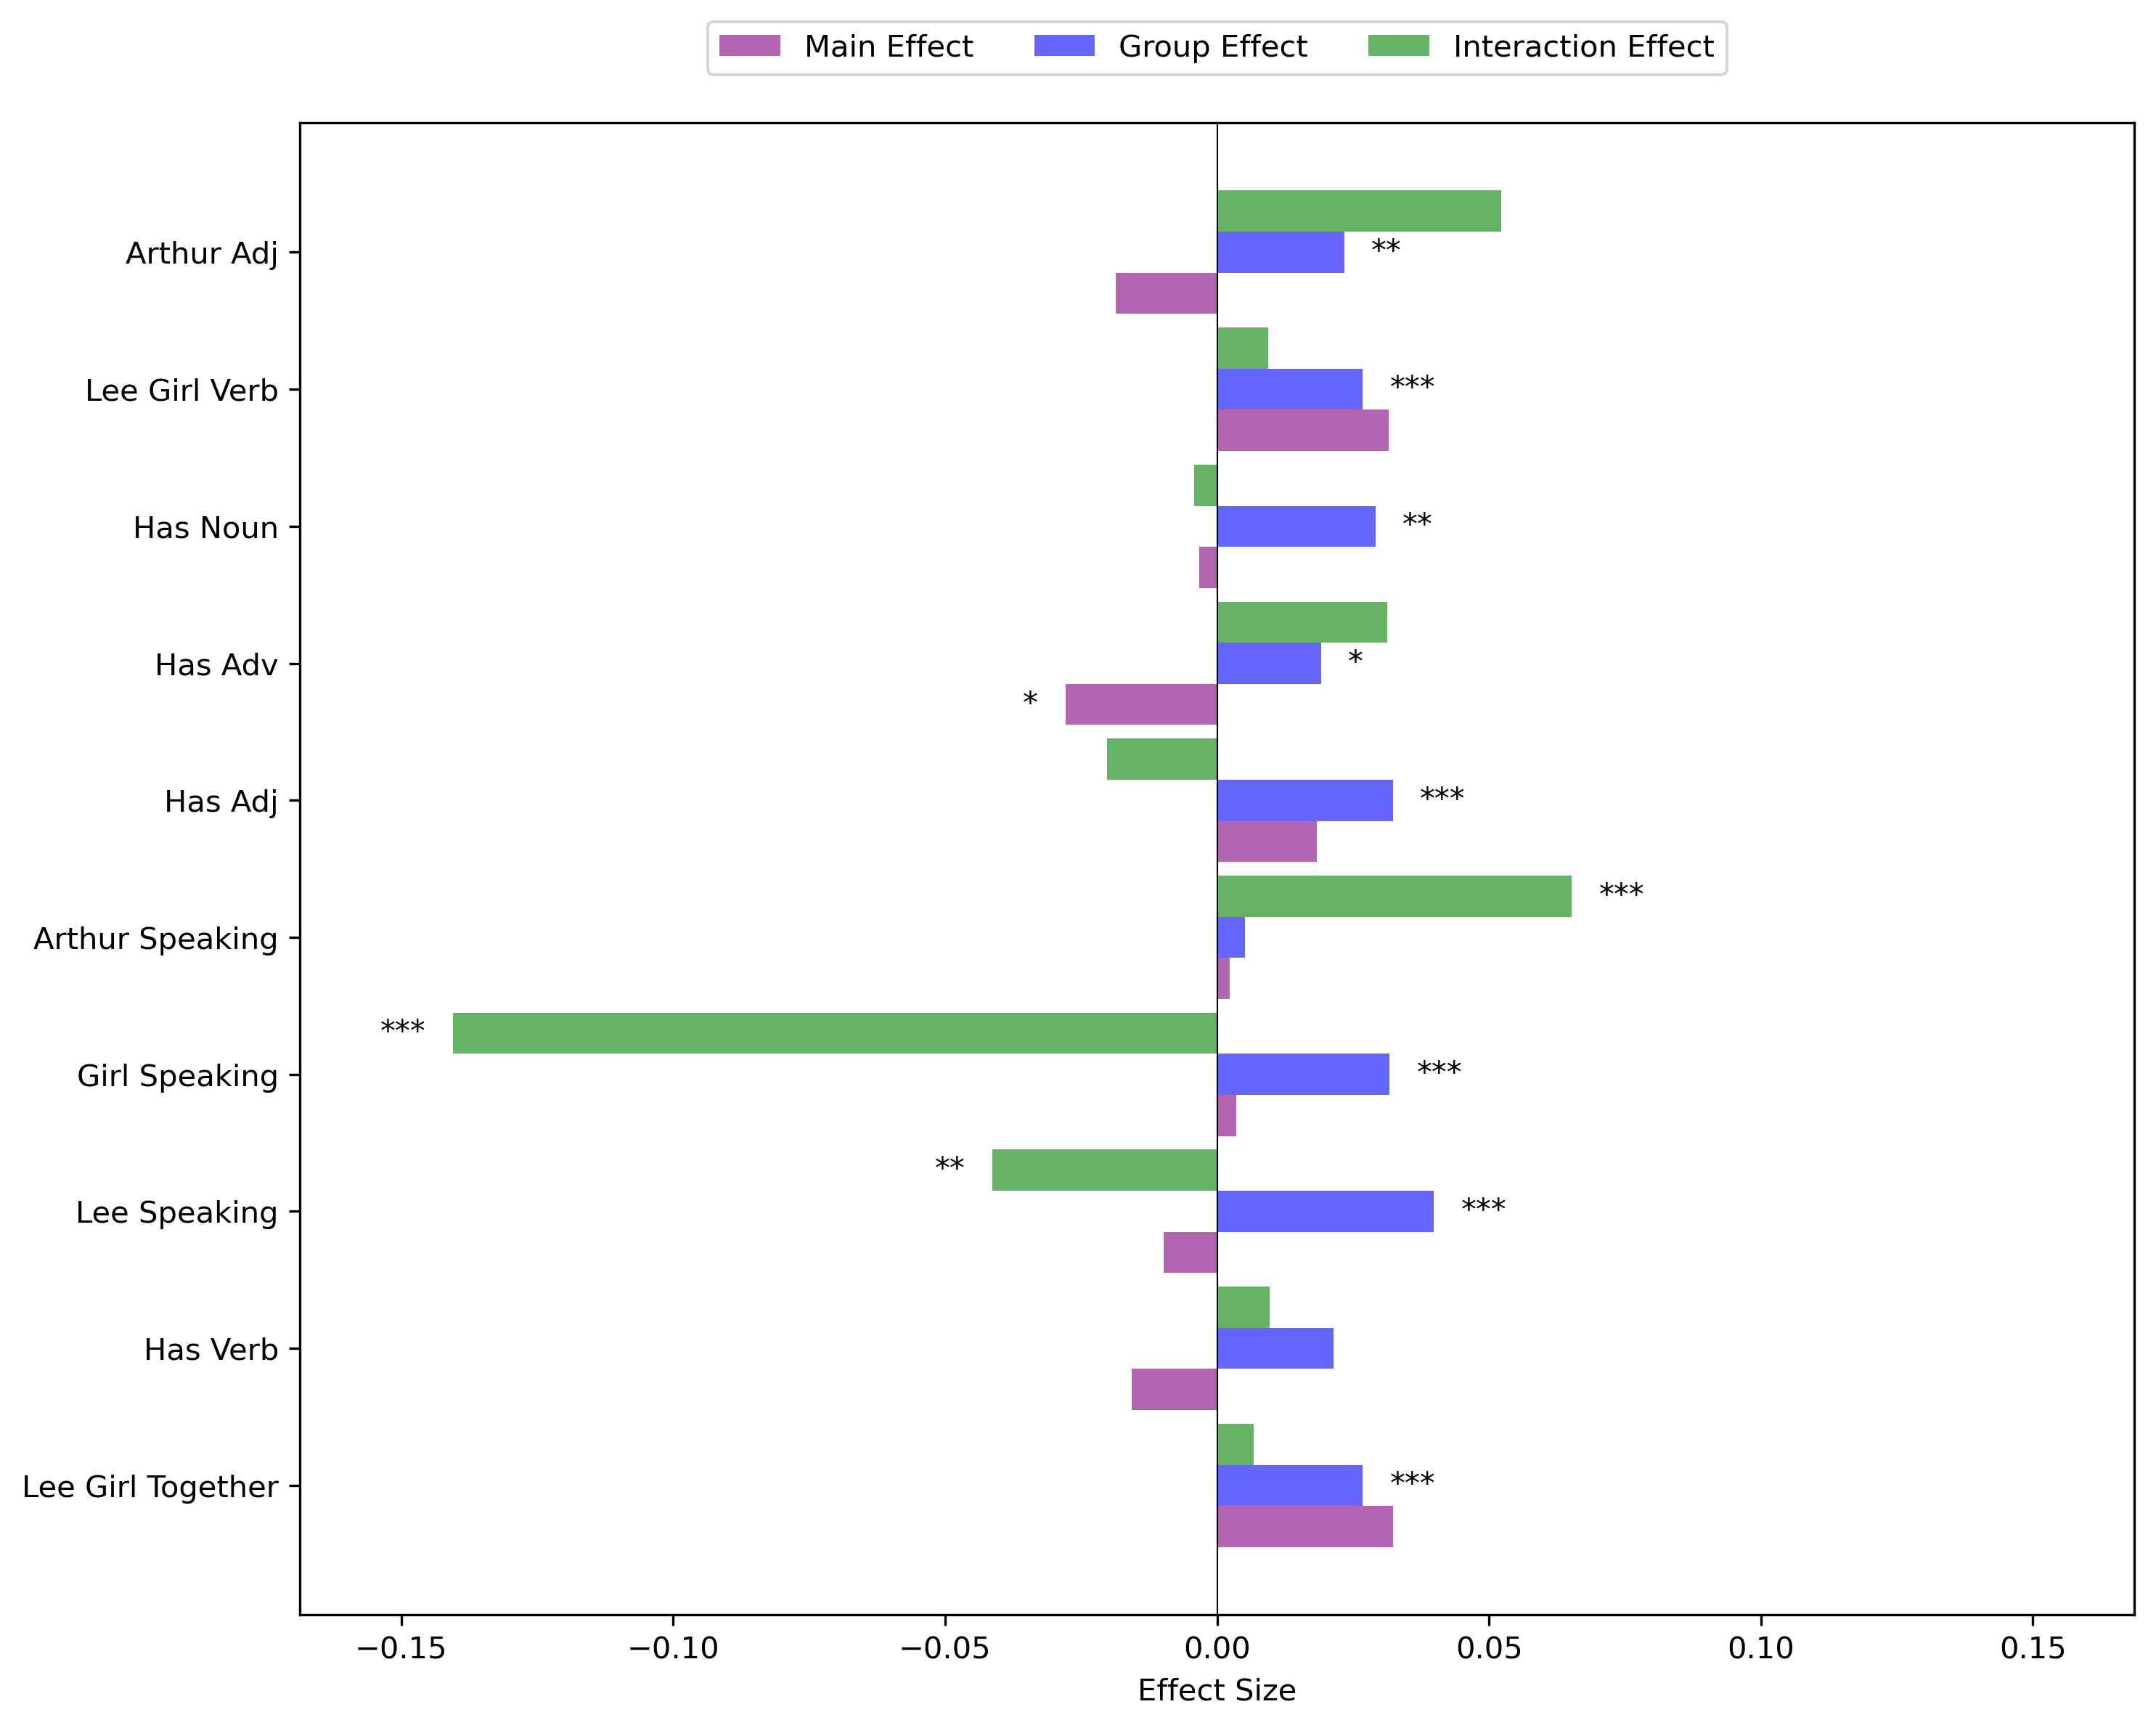

In [14]:
plot_brain_state_effects(main_analysis=main_analysis)

## Figure 4


In [4]:
SAVE_DIR_FIG4 = Path(SAVE_DIR) / "figure4"
SAVE_DIR_FIG4.mkdir(parents=True, exist_ok=True)


In [5]:
affair_beh_file = Path(OUTPUT_DIR) / 'behav_results' / 'individual_response_evidence_affair.pkl'
paranoia_beh_file = Path(OUTPUT_DIR) / 'behav_results' / 'individual_response_evidence_paranoia.pkl'
affair_beh_data = pickle.load(open(affair_beh_file, 'rb'))
paranoia_beh_data = pickle.load(open(paranoia_beh_file, 'rb'))


In [6]:
def safe_eval_response(response, offset=14, n_timepoints=451):
    """
    Safely handle response data with time shift.
    
    Parameters:
    -----------
    response : array-like
        Response data
    offset : int
        Number of TRs to discard from start
    n_timepoints : int
        Total number of timepoints to keep
    """
    if isinstance(response, np.ndarray):
        data = response[offset:offset+n_timepoints]
    elif isinstance(response, list):
        data = np.array(response[offset:offset+n_timepoints])
    else:
        raise ValueError(f"Unexpected response type: {type(response)}")
    
    return data

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_behavioral_responses(affair_data, paranoia_data, offset=14, n_timepoints=451):
    """
    Create visualization of behavioral responses with all participants shown.
    
    Parameters:
    -----------
    affair_data : pd.DataFrame
        DataFrame containing affair group responses
    paranoia_data : pd.DataFrame
        DataFrame containing paranoia group responses
    offset : int
        Number of TRs to discard from start
    n_timepoints : int
        Total number of timepoints to keep after offset
    """
    # Create figure using predefined size
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
    # Set up time points (starting at 0 after offset)
    time_points = np.arange(n_timepoints)
    
    # Calculate vertical spacing based on number of participants
    affair_spacing = 0.4 / len(affair_data)
    paranoia_spacing = 0.4 / len(paranoia_data)
    
    # Process affair group
    affair_responses = []
    
    for idx, row in enumerate(affair_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            affair_responses.append(response)
            
            # Plot individual responses
            response_times = np.where(response == 1)[0]
            ax1.scatter(response_times, 
                       np.ones_like(response_times) * idx * affair_spacing,
                       color=COLORS['affair_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing affair participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for affair group
    if affair_responses:
        affair_responses = np.array(affair_responses)
        affair_avg = affair_responses.mean(axis=0)
        affair_avg_smooth = gaussian_filter1d(affair_avg, sigma=2)
        ax1.plot(time_points, affair_avg_smooth, color=COLORS['affair'], linewidth=1.5)
    
    # Process paranoia group
    paranoia_responses = []
    
    for idx, row in enumerate(paranoia_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            paranoia_responses.append(response)
            
            # Plot individual responses
            response_times = np.where(response == 1)[0]
            ax2.scatter(response_times, 
                       np.ones_like(response_times) * idx * paranoia_spacing,
                       color=COLORS['paranoia_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing paranoia participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for paranoia group
    if paranoia_responses:
        paranoia_responses = np.array(paranoia_responses)
        paranoia_avg = paranoia_responses.mean(axis=0)
        paranoia_avg_smooth = gaussian_filter1d(paranoia_avg, sigma=2)
        ax2.plot(time_points, paranoia_avg_smooth, color=COLORS['paranoia'], linewidth=1.5)
    
    # Customize plots
    ax1.set_ylim(-0.1, 0.5)
    ax2.set_ylim(-0.1, 0.5)
    
    # Add labels
    ax1.set_ylabel('Affair')
    ax2.set_ylabel('Paranoia')
    ax2.set_xlabel('Time (TRs)')
    
    # Add x-axis ticks every 50 TRs
    tick_interval = 50
    ax2.set_xticks(np.arange(0, n_timepoints, tick_interval))
    
    # Remove top and right spines
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

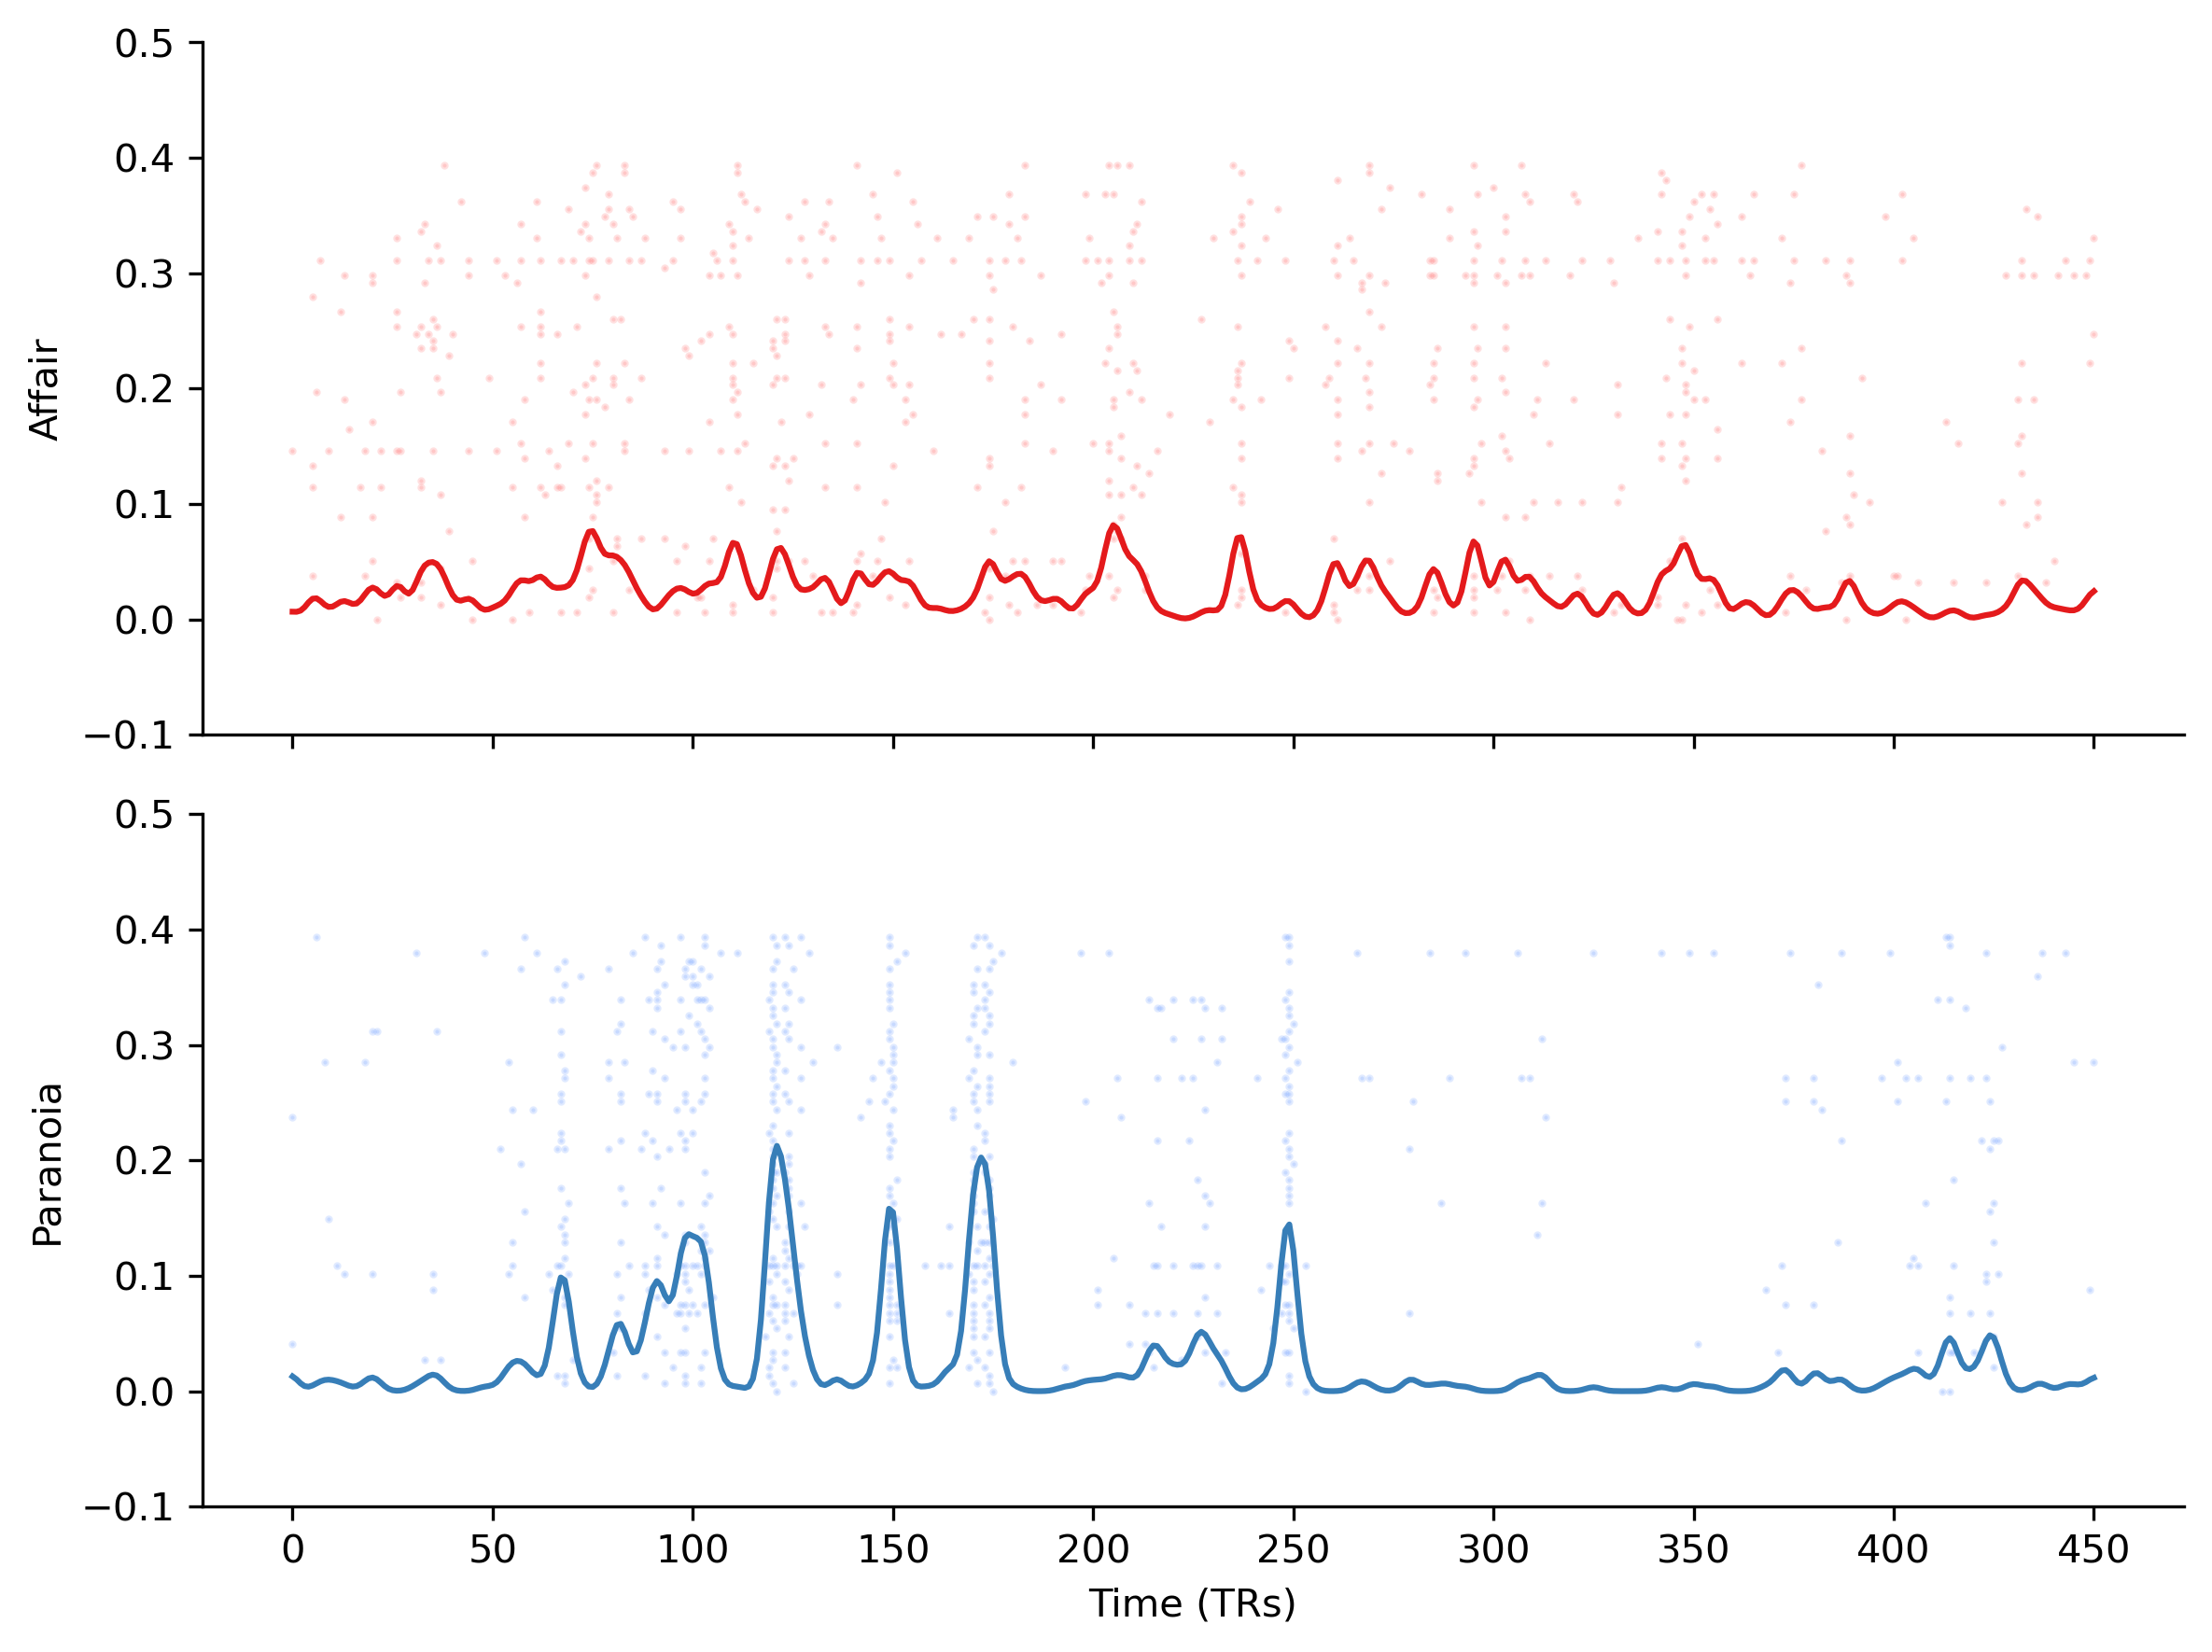

In [8]:
plot_behavioral_responses(affair_beh_data, paranoia_beh_data)

In [9]:
behav_result_file = Path(OUTPUT_DIR) / '12_behavioral_analysis' / 'results.json'

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import sem

def load_results(filename):
    """Load analysis results from JSON file"""
    with open(filename, 'r') as f:
        return json.load(f)

In [51]:
def create_figure1(results):
    """Create figure showing temporal dynamics and group differences"""
    # Create figure using predefined style settings
    fig = plt.figure()
    
    # Panel A: Group Timecourses
    ax1 = plt.subplot(3, 1, 1)
    
    # Get timecourses
    affair_mean = results['group_timecourses']['affair']['mean']
    affair_se = results['group_timecourses']['affair']['se']
    paranoia_mean = results['group_timecourses']['paranoia']['mean']
    paranoia_se = results['group_timecourses']['paranoia']['se']
    
    x = np.arange(len(affair_mean))
    
    # Plot means and error bands using COLORS dictionary
    ax1.plot(x, affair_mean, color=COLORS['affair'], label='Affair', lw=1.5)
    ax1.fill_between(x, 
                     np.array(affair_mean) - np.array(affair_se),
                     np.array(affair_mean) + np.array(affair_se),
                     color=COLORS['affair_light'], alpha=0.2)
    
    ax1.plot(x, paranoia_mean, color=COLORS['paranoia'], label='Paranoia', lw=1.5)
    ax1.fill_between(x, 
                     np.array(paranoia_mean) - np.array(paranoia_se),
                     np.array(paranoia_mean) + np.array(paranoia_se),
                     color=COLORS['paranoia_light'], alpha=0.2)
    
    ax1.set_xlabel('Time (TRs)')
    ax1.set_ylabel('Button Press Probability')
    ax1.legend()
    
    # Panel B: Statistical Differences
    ax2 = plt.subplot(3, 1, 2)
    
    # Convert p-values to -log10(q)
    qvals = np.array(results['timepoint_differences']['qvals'])
    log_q = -np.log10(qvals)
    
    # Plot -log10(q) values
    ax2.plot(x, log_q, color='#666666', lw=1)
    
    # Add significance threshold
    threshold = -np.log10(0.05)
    ax2.axhline(y=threshold, color=COLORS['affair'], linestyle='--', alpha=0.5)
    
    # Mark significant timepoints
    sig_points = qvals < 0.05
    ax2.scatter(x[sig_points], log_q[sig_points], 
                color=COLORS['affair'], marker='*', s=50, alpha=0.5)
    
    ax2.set_xlabel('Time (TRs)')
    ax2.set_ylabel('-log10(q-value)')
    
    # Panel C: Effect Sizes
    ax3 = plt.subplot(3, 1, 3)
    
    effect_sizes = results['timepoint_differences']['effect_sizes']
    
    # Plot effect sizes
    ax3.plot(x, effect_sizes, color='#666666', lw=1)
    
    # Add effect size thresholds using consistent colors
    ax3.axhline(y=0.2, color=COLORS['affair'], linestyle='--', alpha=0.5, label='Small')
    ax3.axhline(y=0.5, color=COLORS['paranoia'], linestyle='--', alpha=0.5, label='Medium')
    ax3.axhline(y=0.8, color=COLORS['paranoia_light'], linestyle='--', alpha=0.5, label='Large')
    
    ax3.set_xlabel('Time (TRs)')
    ax3.set_ylabel("Cohen's d")
    ax3.legend()
    
    # Remove top and right spines for all axes
    for ax in [ax1, ax2, ax3]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

In [48]:
from matplotlib.lines import Line2D 

def create_feature_effects_plot(results):
    """Create figure showing content feature effects split by group"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Define features with Has Adj at the bottom
    features = ['has_adj', 'has_adv', 'has_noun', 'arthur_speaking',
                'girl_speaking', 'lee_speaking', 'has_verb', 'lee_girl_together']
    
    # Define colors
    ns_color = '#666666'  # Gray
    
    # Prepare data for both groups
    affair_data = {
        'feature': features,
        'coefficient': [float(results['content_relationships']['coefficients'][f]) 
                       for f in features],
        'pvalue': [float(results['content_relationships']['pvalues'][f]) 
                  for f in features],
        'ci_lower': [float(results['content_relationships']['confidence_intervals']['0'][f]) 
                    for f in features],
        'ci_upper': [float(results['content_relationships']['confidence_intervals']['1'][f]) 
                    for f in features]
    }
    
    paranoia_data = {
        'feature': features,
        'coefficient': [float(results['content_relationships']['coefficients'][f]) +
                       float(results['content_relationships']['coefficients'][f'group_{f}_interaction'])
                       for f in features],
        'pvalue': [float(results['content_relationships']['pvalues'][f'group_{f}_interaction']) 
                  for f in features],
        'ci_lower': [float(results['content_relationships']['confidence_intervals']['0'][f]) +
                    float(results['content_relationships']['confidence_intervals']['0'][f'group_{f}_interaction'])
                    for f in features],
        'ci_upper': [float(results['content_relationships']['confidence_intervals']['1'][f]) +
                    float(results['content_relationships']['confidence_intervals']['1'][f'group_{f}_interaction'])
                    for f in features]
    }
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    def plot_group(ax, df, title, group_color):
        # Determine significance based on both p-value and CI
        colors = []
        significance = []  # Store significance level for stars
        for _, row in df.iterrows():
            # Check if CI excludes zero and p < 0.05
            is_significant = (not (row['ci_lower'] <= 0 <= row['ci_upper'])) and (row['pvalue'] < 0.05)
            colors.append(group_color if is_significant else ns_color)
            
            # Store significance level only if CI excludes zero
            if not (row['ci_lower'] <= 0 <= row['ci_upper']):
                if row['pvalue'] < 0.001:
                    significance.append('***')
                elif row['pvalue'] < 0.01:
                    significance.append('**')
                elif row['pvalue'] < 0.05:
                    significance.append('*')
                else:
                    significance.append('')
            else:
                significance.append('')
        
        # Plot coefficients
        y_pos = np.arange(len(df))
        ax.scatter(df['coefficient'], y_pos, c=colors, s=100)
        
        # Add error bars
        for i, (_, row) in enumerate(df.iterrows()):
            ax.hlines(y_pos[i], row['ci_lower'], row['ci_upper'], 
                     color=colors[i], alpha=0.5, linewidth=2)
        
        # Customize plot
        ax.axvline(x=0, color='#666666', linestyle='--', alpha=0.5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f.replace('_', ' ').title() for f in df['feature']], fontsize=10)
        ax.set_xlabel('Effect Size (β)', fontsize=12)
        ax.set_title(title, fontsize=14)
        
        # Add significance markers only for truly significant effects
        max_ci = max(df['ci_upper'])
        min_ci = min(df['ci_lower'])
        marker_offset = (max_ci - min_ci) * 0.05
        
        for i, sig in enumerate(significance):
            if sig:  # Only add stars if there's a significance level
                ax.text(max_ci + marker_offset, i, sig, ha='left', va='center', fontsize=12)
        
        # Adjust plot limits to show significance markers
        ax.set_xlim(min_ci - marker_offset, max_ci + marker_offset * 4)
        
        # Add legend at the bottom
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=group_color,
                  label='p < 0.05 & CI excludes 0', markersize=10),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=ns_color,
                  label='n.s. or CI includes 0', markersize=10)
        ]
        ax.legend(handles=legend_elements, loc='lower right')
    
    # Create plots using COLORS from your settings
    plot_group(ax1, df_affair, 'Affair Group Effects', COLORS['affair'])
    plot_group(ax2, df_paranoia, 'Paranoia Group Effects', COLORS['paranoia'])
    
    plt.tight_layout()
    return fig

In [12]:
results = load_results(behav_result_file)

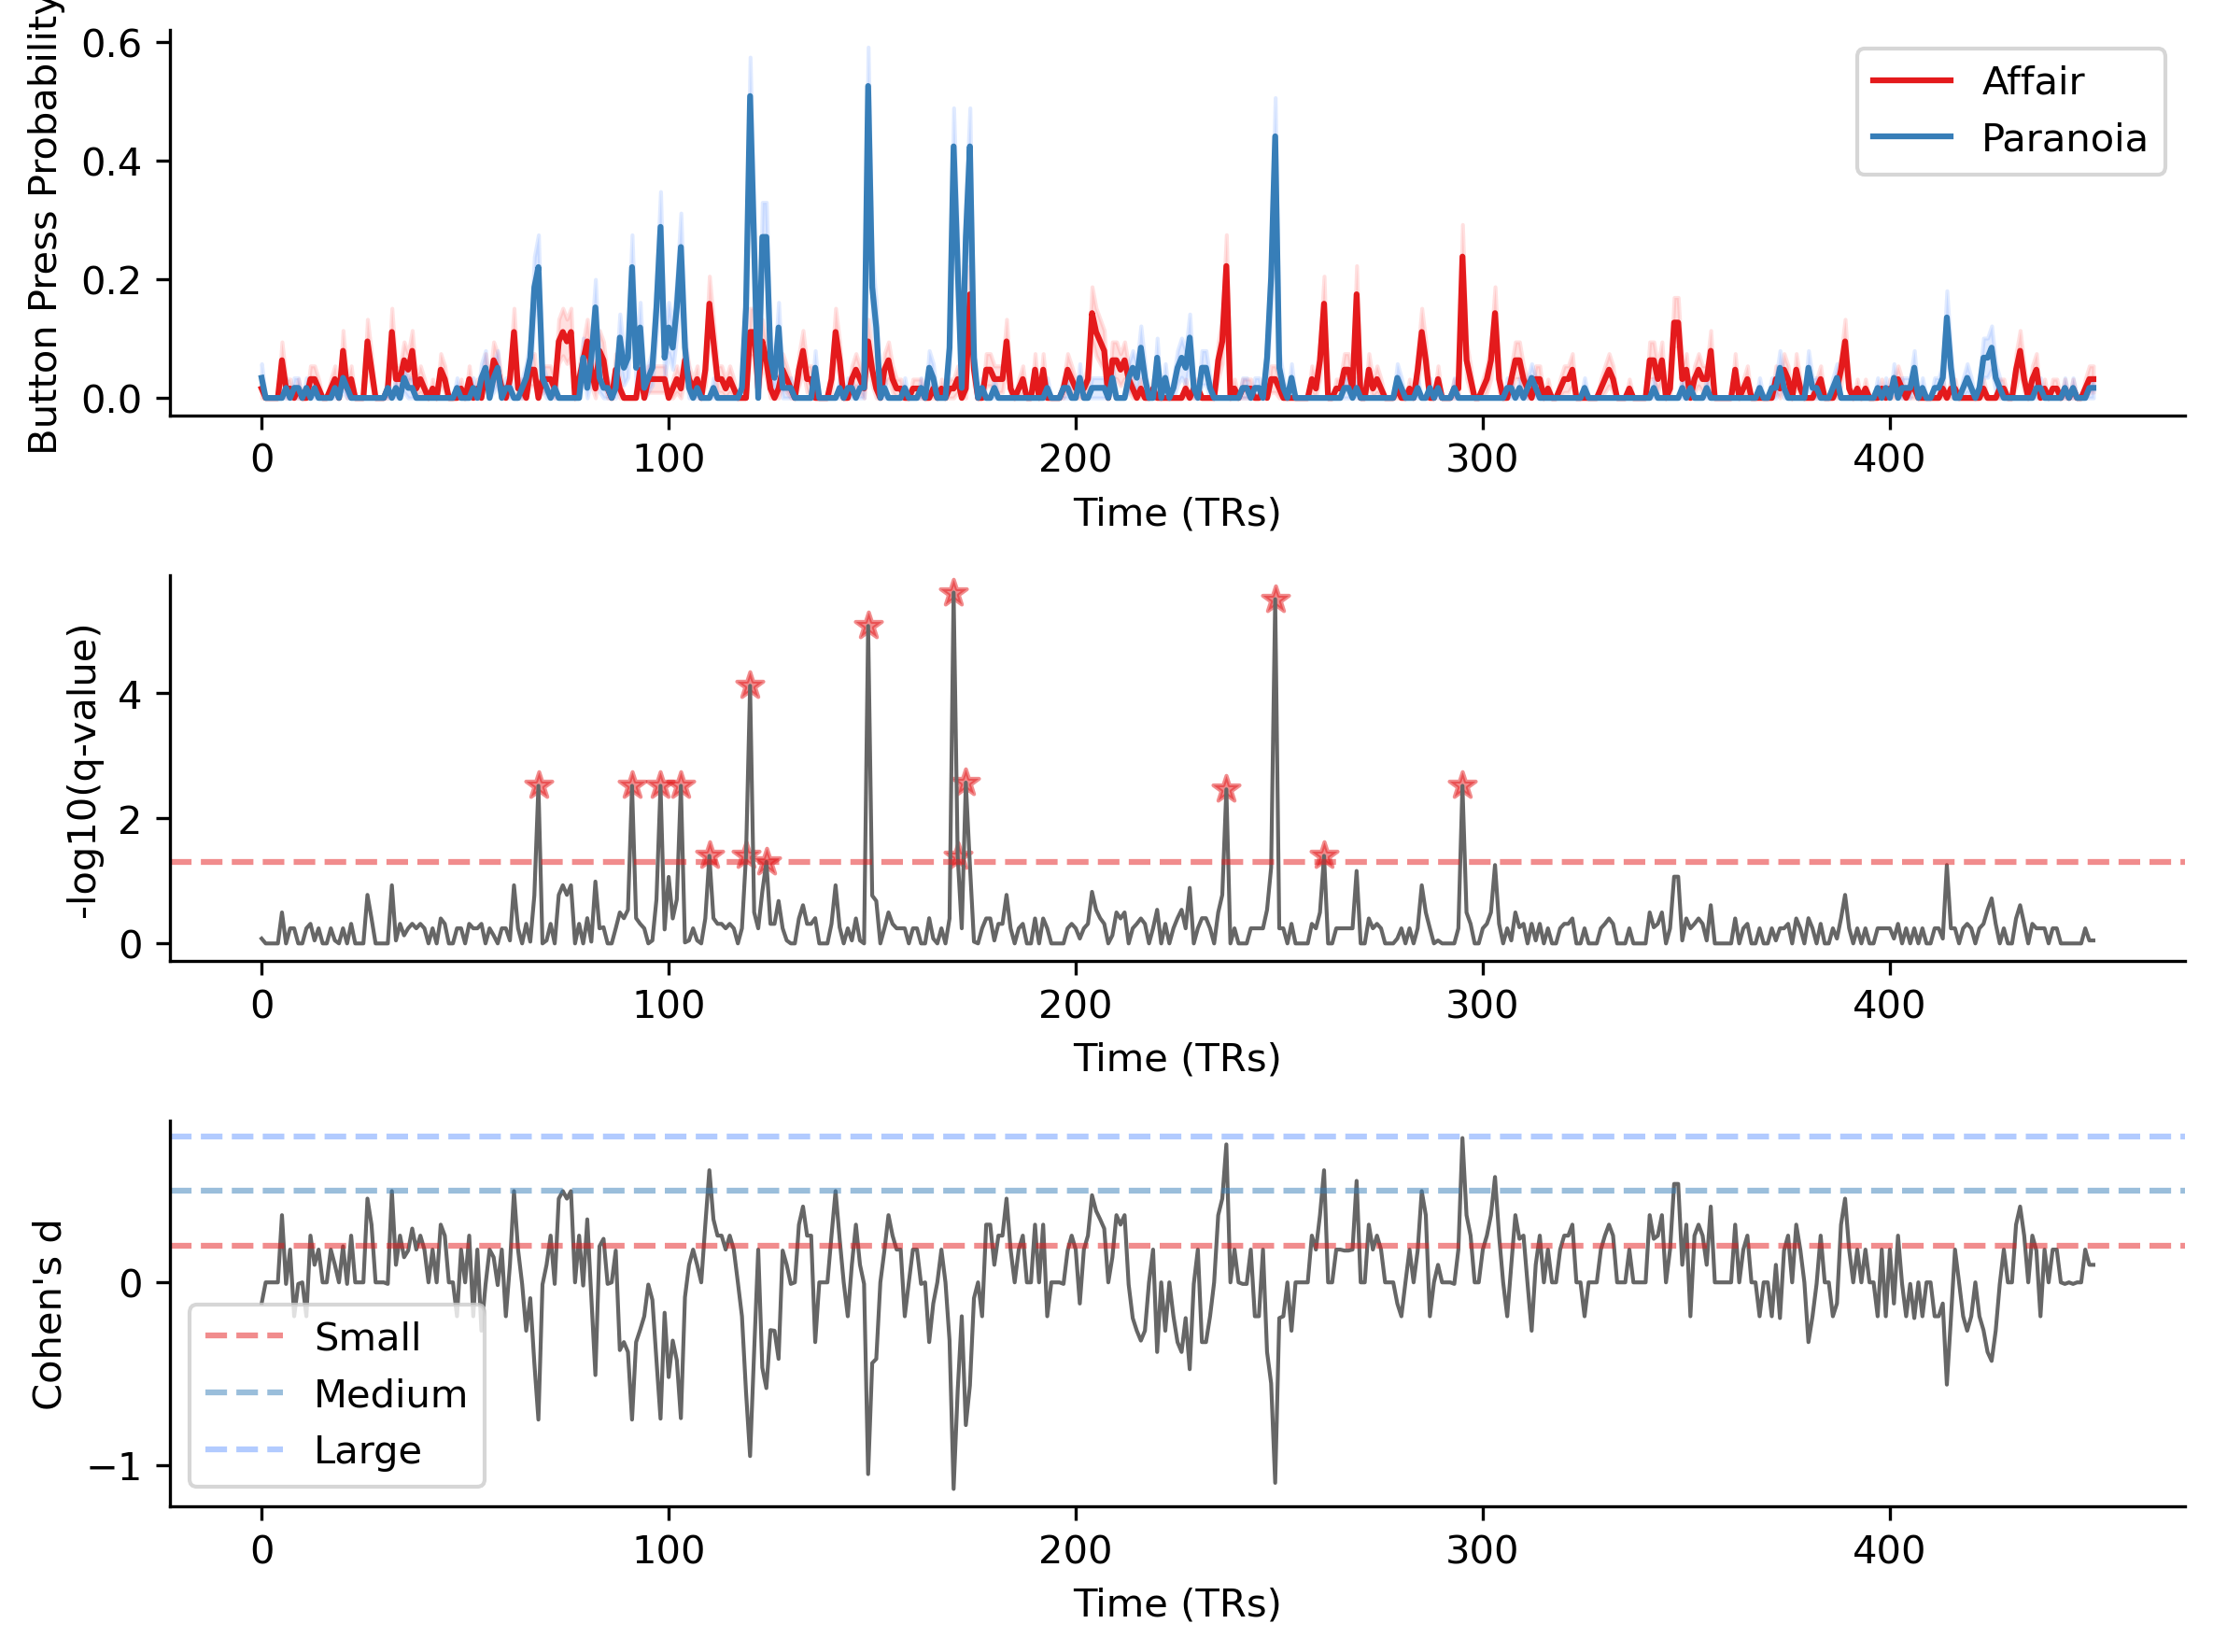

In [52]:
create_figure1(results)

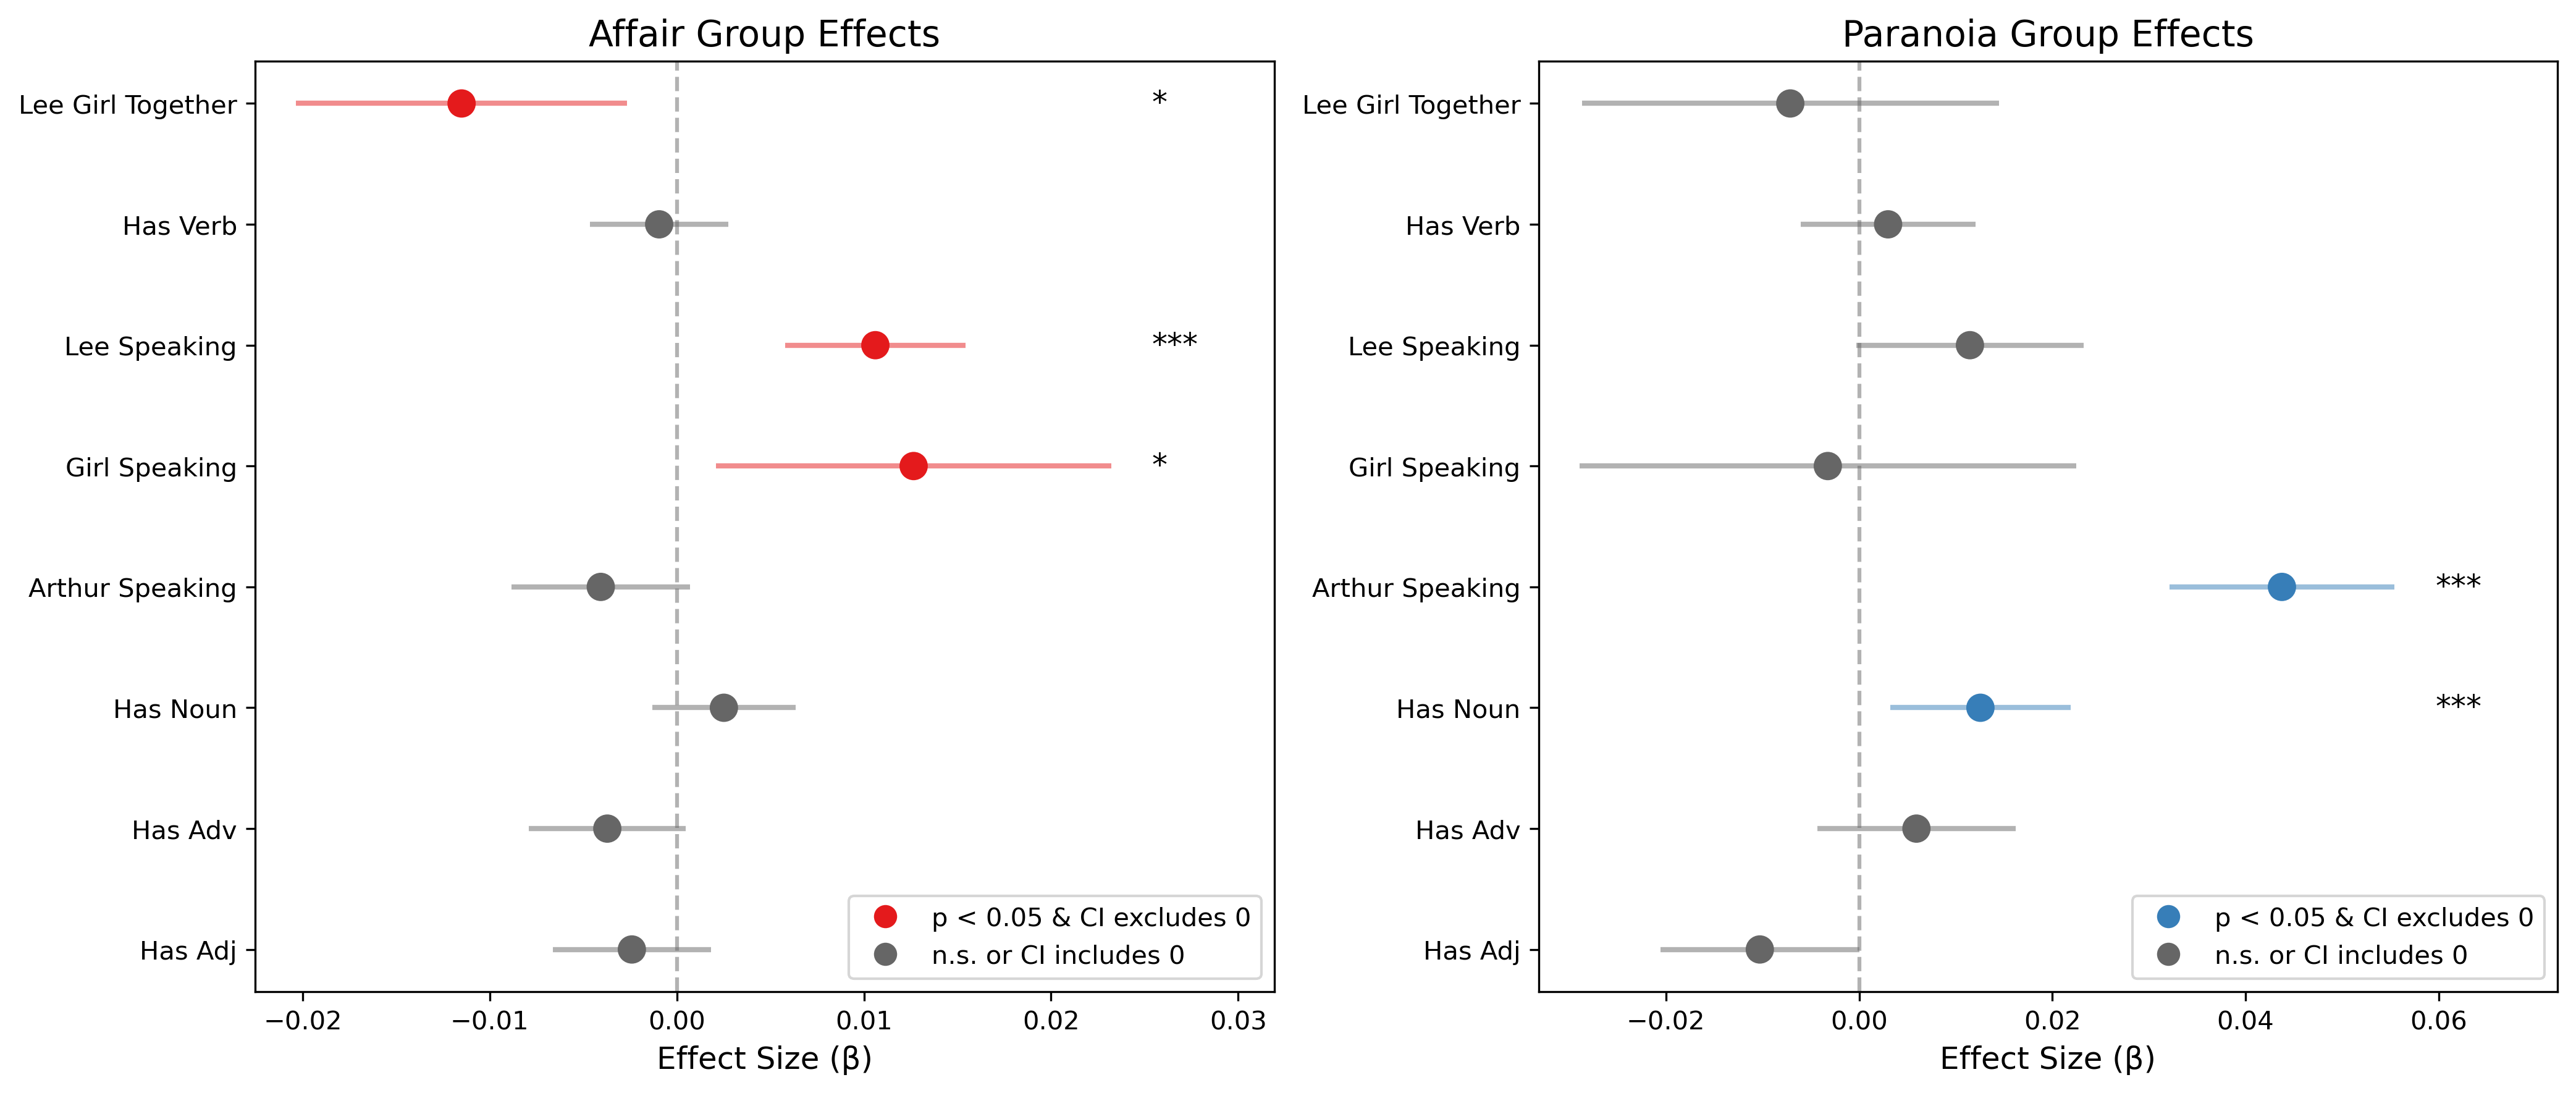

In [49]:
create_feature_effects_plot(results)